<a href="https://colab.research.google.com/github/AsiyatShch/Internship/blob/Anna/Study_of_gesture_prediction_Anna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
pip install optuna

In [82]:
pip install catboost

In [83]:
pip install pyod

In [154]:
pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver doe

In [85]:
#pip install tensorflow protobuf==3.20.3 absl-py==0.14.1

# Libraries

In [86]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import f1_score
#import optuna
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
#import catboost
#from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization, Dropout, TimeDistributed, Dense
from keras.layers import Input, LSTM, Dense, Bidirectional, concatenate, Flatten
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

In [87]:
!git clone https://github.com/MaxBalashov/motorica-x-skillfactory-gestures.git

fatal: destination path 'motorica-x-skillfactory-gestures' already exists and is not an empty directory.


In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IO utils


In [89]:
def read_omg_csv(path_palm_data: str,
                 n_omg_channels: int,
                 n_acc_channels: int = 0,
                 n_gyr_channels: int = 0,
                 n_mag_channels: int = 0,
                 n_enc_channels: int = 0,
                 button_ch: bool = True,
                 sync_ch: bool = True,
                 timestamp_ch: bool = True) -> pd.DataFrame:

    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''

    df_raw = pd.read_csv(path_palm_data, sep=' ',
                         header=None,
                         skipfooter=1,
                         skiprows=1,
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()

    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'],
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]

    if button_ch:
        columns = columns + ['BUTTON']

    if sync_ch:
        columns = columns + ['SYNC']

    if timestamp_ch:
        columns = columns + ['ts']

    df_raw.columns = columns

    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [90]:
palm_file = 'motorica-x-skillfactory-gestures/data/2023-05-05_17-57-30.palm'
gestures = read_omg_csv(palm_file,
                              n_omg_channels=50,
                              n_acc_channels=3,
                              n_gyr_channels=3,
                              n_enc_channels=6,
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(26648, 65)


0   1   2     3     4     5     6   7  8   9  ...  GYR2  ENC0  ENC1  ENC2  \
0   0  11  58  3462  3692  3417  1868  13  7   5  ...    -1     0     0     0   
1  10   8  51  3463  3693  3418  1870  21  6   6  ...     4     0     0     0   
2  11   9  58  3463  3692  3418  1871  13  6   6  ...     6     0     0     0   
3  11   8  58  3460  3692  3418  1869  13  6   5  ...     7     0     0     0   
4  24   8  58  3460  3691  3417  1856  13  7  12  ...     8     0     0     0   

   ENC3  ENC4  ENC5  BUTTON  SYNC      ts  
0     0     0     0       0     0  161823  
1     0     0     0       0     0  161856  
2     0     0     0       0     0  161889  
3     0     0     0       0     0  161922  
4     0     0     0       0     0  161955  

[5 rows x 65 columns]

In [91]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [92]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


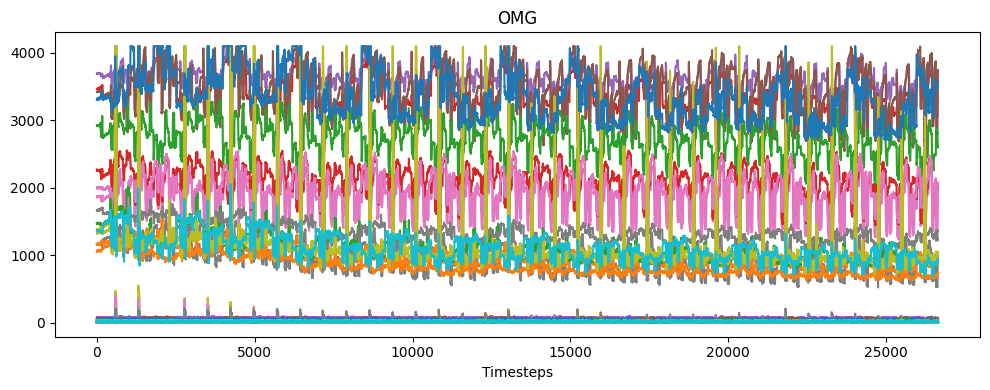

In [93]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [94]:
def plot_ts(y_train,y_pred_train,y_test,y_pred_test):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
  axes[0].plot(y_train, c='C0', label='y_true')
  axes[0].plot(y_pred_train, c='C1', label='y_pred')
  axes[0].set_yticks(np.arange(len(GESTURES)))
  axes[0].grid()
  axes[0].set_xlabel('Timesteps')
  axes[0].legend()
  axes[0].set_title('Train')
  # Plot for Test Set
  axes[1].plot(y_test, c='C0', label='y_true')
  axes[1].plot(y_pred_test, c='C1', label='y_pred')
  axes[1].set_yticks(np.arange(len(GESTURES)))
  axes[1].grid()
  axes[1].set_xlabel('Timesteps')
  axes[1].legend()
  axes[1].set_title('Test')

  plt.tight_layout()
  plt.show()

### Protocol

In [95]:
gestures_protocol = pd.read_csv('motorica-x-skillfactory-gestures/data/2023-05-05_17-57-30.palm.protocol.csv', index_col=0)
gestures_protocol.head(10)

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
5        1.0    1.0     0.0   0.0    0.0            0.0            0.0   
6        0.0    0.0     1.0   1.0    1.0            0.0            0.0   
7        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
8        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
9        1.0    1.0     1.0   1.0    1.0            0.0            0.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
5                 0.0           0.0            0.0        0.0  
6                 0.0           0.0            0.0        0.0  
7                 0.0           0.0            0.0        0.5  
8                 0.0           0.0            0.0        0.5  
9                 0.0           0.0            0.0        0.5

In [96]:
gestures_protocol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Thumb           217 non-null    float64
 1   Index           217 non-null    float64
 2   Middle          217 non-null    float64
 3   Ring            217 non-null    float64
 4   Pinky           217 non-null    float64
 5   Thumb_stretch   217 non-null    float64
 6   Index_stretch   217 non-null    float64
 7   Middle_stretch  217 non-null    float64
 8   Ring_stretch    217 non-null    float64
 9   Pinky_stretch   217 non-null    float64
 10  Pronation       217 non-null    float64
dtypes: float64(11)
memory usage: 20.3 KB


In [97]:
gestures['SYNC'].value_counts()

0      13599
9         62
34        62
144       62
117       62
       ...  
130       59
98        59
191       59
166       59
175       59
Name: SYNC, Length: 217, dtype: int64

In [98]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [99]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [100]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
212    3
213    5
214    1
215    4
216    2
Name: gesture, Length: 217, dtype: int64

In [101]:
print(gestures['SYNC'].values)

[0 0 0 ... 0 0 0]


In [102]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

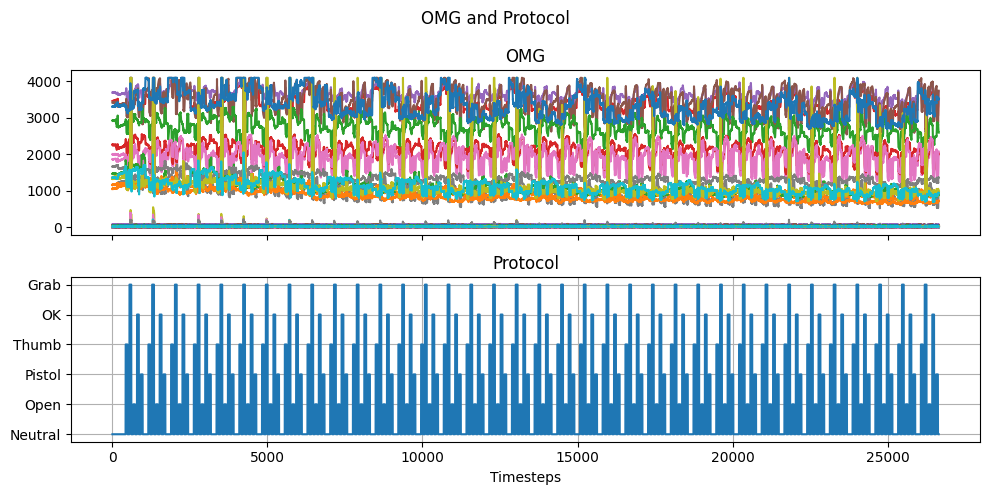

In [103]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [104]:
df_meta = pd.read_csv('motorica-x-skillfactory-gestures/data/meta_information.csv', index_col=0)
df_meta.head()

montage  pilote_id  last_train_idx  len(train)  len(test)
0  2023-05-15_16-16-08.palm          1           23337       23337       5810
1  2023-05-15_17-12-24.palm          1           23336       23336       5803
2  2023-06-05_16-12-38.palm          1           17939       17939       4431
3  2023-06-05_17-53-01.palm          1           17771       17771       4435
4  2023-06-20_14-43-11.palm          1           17936       17936       4441

In [105]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20756, 50) (20756,)
(5892, 50) (5892,)


# Modeling

In [106]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(
    X=X_train,
    y=y_train
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

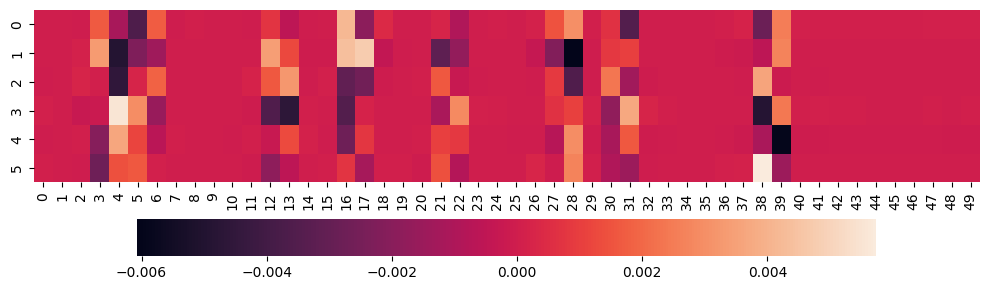

In [107]:
import seaborn as sns

plt.figure(figsize=(10, 3)) #
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [108]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

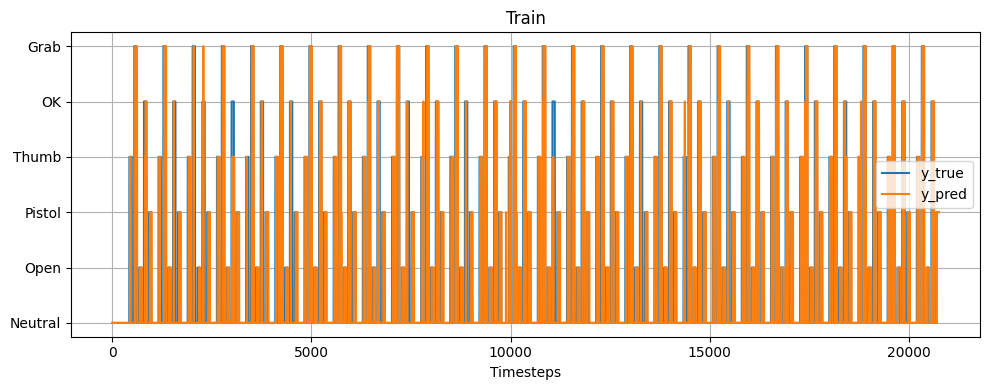

In [109]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

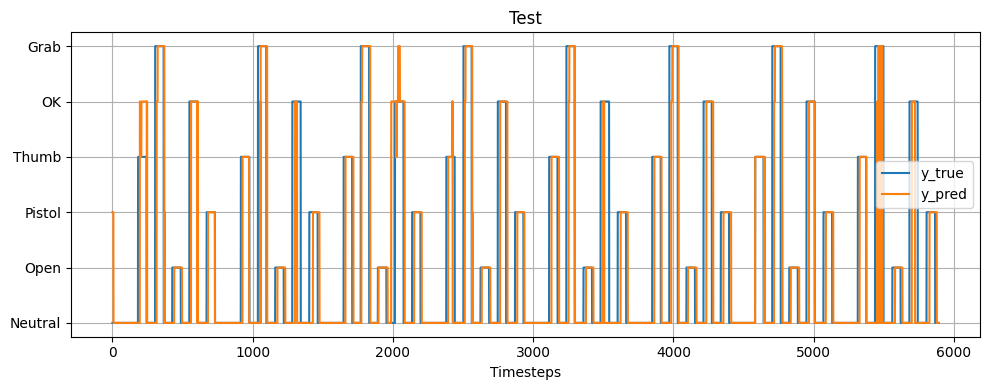

In [110]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [111]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.79      0.92      0.85     12287
        Open       0.82      0.71      0.76      1694
      Pistol       0.80      0.67      0.73      1696
       Thumb       0.82      0.66      0.73      1693
          OK       0.74      0.42      0.54      1692
        Grab       0.88      0.68      0.77      1694

    accuracy                           0.80     20756
   macro avg       0.81      0.68      0.73     20756
weighted avg       0.80      0.80      0.79     20756

              precision    recall  f1-score   support

     Neutral       0.82      0.91      0.87      3483
        Open       0.82      0.79      0.81       486
      Pistol       0.79      0.70      0.74       482
       Thumb       0.90      0.68      0.78       484
          OK       0.65      0.54      0.59       478
        Grab       0.85      0.67      0.75       479

    accuracy                           0.82      5892
   macro avg       0.81

# The difference train vs test

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df_full = gestures[OMG_CH]
display(df_full.shape)
df_full['gestures'] = pd.Series(y_cmd)
df_full['class'] = [1 if i < last_train_idx else 0 for i in df_full.index]
df_full['class'].value_counts()

X = df_full.drop(['class'], axis=1)
y = df_full['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))


(26648, 50)

<ipython-input-112-b90d9aac3797>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-112-b90d9aac3797>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Training Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      4725
           1       0.90      0.94      0.92     16593

    accuracy                           0.87     21318
   macro avg       0.82      0.79      0.81     21318
weighted avg       0.87      0.87      0.87     21318

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1167
           1       0.90      0.94      0.92      4163

    accuracy                           0.87      5330
   macro avg       0.82      0.78      0.80      5330
weighted avg       0.87      0.87      0.87      5330



# Preprocessing

## Selection of important features

### DecisionTreeClassifier

In [ ]:
'''
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

X_train = df.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = df.values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    max_depth=48,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features=0.71,
    random_state=42
)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = gestures[OMG_CH].columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
cols = feature_names[indices][:12]
print(cols)
df_selected = gestures[cols]
df_selected.head()
'''

### K best


In [ ]:
'''
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=12)
selected = selector.fit_transform(gestures[OMG_CH], y_cmd)
selected_indices = selector.get_support(indices=True)
cols = [str(element) for element in selected_indices]
df_selected = gestures[cols]
display(cols,
    df_selected.head())
'''

### Std. dif

In [113]:
df = gestures[OMG_CH].copy()
df['gest'] = pd.Series(y_cmd)
df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')

# Calculate standard deviation for each column, grouped by label
std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
fig = px.bar(std_dev_per_label.sort_values(by='std_dif', ascending=False),
             x='column', y='std_dif', title='Absolute Difference of Standard Deviation')
fig.show()


imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
display(imp_features)


['28', '27', '21', '38', '17', '16', '5', '6', '3', '13', '12', '31']

In [114]:
dt = set(['16', '28', '21', '27', '31', '38', '13', '17', '30', '22', '39', '12'])
f = set(['13', '16', '17', '21', '23', '26', '28', '30', '31', '37', '38', '43'])
std = set(['30', '16', '21', '28', '31', '38', '17', '27', '39', '13', '22', '12'])
display(dt.intersection(std),len(dt.intersection(std)),
        f.intersection(std),len(f.intersection(std)) )


{'12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39'}

12

{'13', '16', '17', '21', '28', '30', '31', '38'}

8

In [115]:
df_selected = df[imp_features]

In [116]:
df_selected.columns

Index(['28', '27', '21', '38', '17', '16', '5', '6', '3', '13', '12', '31'], dtype='object')

In [117]:
std_dev_per_label.sort_values(by='std_dif', ascending=False)

column           0           1     std_dif
29     28  284.423924  846.672432  562.248508
28     27  191.868252  492.671405  300.803153
22     21  208.604849   472.65533  264.050481
39     38  149.999547  397.037906  247.038359
18     17  206.518253  402.930539  196.412286
17     16  214.153406  348.136344  133.982938
6       5  336.836707  462.225566  125.388859
7       6  226.604593  342.136165  115.531572
4       3  258.427152  368.115154  109.688002
14     13   183.65232  290.987997  107.335677
13     12  197.193801  299.093163  101.899362
32     31  139.529459  223.005687   83.476228
5       4  178.581555  258.127174   79.545618
23     22  207.114912  256.717739   49.602827
19     18   13.888801   43.471404   29.582603
38     37    9.270481   31.447105   22.176624
27     26    5.784417   24.537755   18.753337
30     29    5.997455   21.474582   15.477126
40     39  187.224853  199.714133    12.48928
21     20    8.176827   15.022275    6.845448
12     11    6.475027    12.89406    6.419032
37     36    1.972987    7.212401    5.239413
31     30  358.404655  354.694453    3.710202
3       2    9.251871   12.763238    3.511367
20     19    1.656588    4.049828     2.39324
16     15    6.387021    8.226342    1.839322
15     14    5.646096    7.299326     1.65323
33     32     6.43111    7.723401    1.292292
24     23    3.975744    4.525327    0.549583
49     48    2.082922    2.616811    0.533889
8       7    2.525585    2.846908    0.321323
48     47    1.798556    2.035943    0.237386
47     46    1.673465    1.844956    0.171491
42     41    3.213825    3.380614    0.166789
41     40     4.86098    4.994565    0.133584
1       0    5.123048    5.251483    0.128435
11     10     5.73938    5.836483    0.097103
44     43     1.76274    1.672064    0.090676
46     45    1.567143    1.653906    0.086763
36     35    1.278888    1.326407     0.04752
34     33    1.870745    1.913498    0.042753
35     34    1.356095    1.386416    0.030321
45     44     1.78455    1.754728    0.029822
25     24    1.546238    1.574384    0.028146
50     49    1.819787    1.834506    0.014718
9       8    1.781812    1.769758    0.012054
43     42     2.55193    2.560219    0.008289
26     25    1.666109    1.674371    0.008263
2       1    2.269043    2.267291    0.001752
10      9    1.519248    1.520934    0.001686

### select features with no difference train vs test

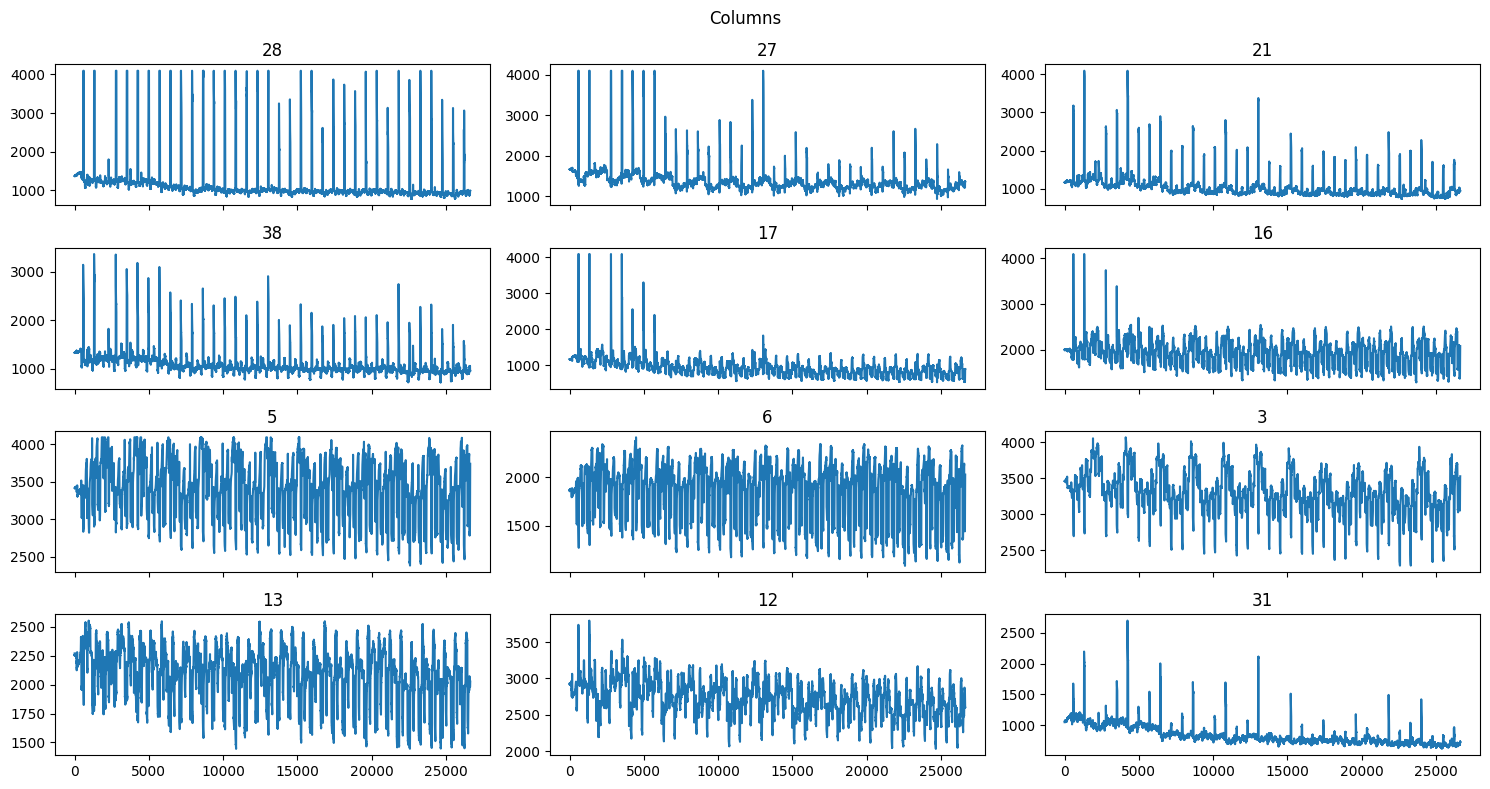

In [118]:
fig, axx = plt.subplots(4, 3, sharex=True, figsize=(15, 8))
cols = list(df_selected.columns)

for i in range(4):
    for j in range(3):
        # Calculate the column index
        col_index = i * 3 + j
        if col_index < len(cols):
            ax = axx[i, j]
            # Plot the data from the corresponding column
            ax.plot(df_selected.iloc[:, col_index].values)
            ax.set_title(f'{cols[col_index]}')  # Set the subplot title

# Add an overall title and adjust layout
plt.suptitle('Columns')
plt.tight_layout()
plt.show()

In [119]:
'''
X_train = df_selected.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = df_selected.values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

indices_train = np.where(y_train == 0)[0]
indices_test = np.where(y_test == 0)[0]

X_gest_train = X_train[indices_train]
X_gest_test = X_test[indices_test]

normal_cols = []

for col_idx, col in enumerate(df_selected.columns):
    mode_train = np.argmax(np.bincount(X_gest_train[:, col_idx]))  # Find mode using bincount and argmax
    mode_test = np.argmax(np.bincount(X_gest_test[:, col_idx]))
    if (mode_train - mode_test) / mode_train < 0.1:
        normal_cols.append(col)

print(len(normal_cols))

fig, axx = plt.subplots(4, 2, sharex=True, figsize=(15, 8))

for i in range(4):
    for j in range(2):
        # Calculate the column index
        col_index = i * 2 + j
        if col_index < len(normal_cols):
            ax = axx[i, j]
            # Plot the data from the corresponding column
            ax.plot(df_selected[normal_cols].iloc[:, col_index].values)
            ax.set_title(f'{normal_cols[col_index]}')  # Set the subplot title

# Add an overall title and adjust layout
plt.suptitle('Columns')
plt.tight_layout()
plt.show()

df_selected=df_selected[normal_cols]
'''

"\nX_train = df_selected.values[:last_train_idx]\ny_train = y_cmd[:last_train_idx]\n\nX_test = df_selected.values[last_train_idx:]\ny_test = y_cmd[last_train_idx:]\n\nindices_train = np.where(y_train == 0)[0]\nindices_test = np.where(y_test == 0)[0]\n\nX_gest_train = X_train[indices_train]\nX_gest_test = X_test[indices_test]\n\nnormal_cols = []\n\nfor col_idx, col in enumerate(df_selected.columns):\n    mode_train = np.argmax(np.bincount(X_gest_train[:, col_idx]))  # Find mode using bincount and argmax\n    mode_test = np.argmax(np.bincount(X_gest_test[:, col_idx]))\n    if (mode_train - mode_test) / mode_train < 0.1:\n        normal_cols.append(col)\n\nprint(len(normal_cols))\n\nfig, axx = plt.subplots(4, 2, sharex=True, figsize=(15, 8))\n\nfor i in range(4):\n    for j in range(2):\n        # Calculate the column index\n        col_index = i * 2 + j\n        if col_index < len(normal_cols):\n            ax = axx[i, j]\n            # Plot the data from the corresponding column\n      

## Feature importances for every class with ts fresh

In [120]:
#pip install tsfresh

In [121]:
'''
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tsfresh.feature_extraction import MinimalFCParameters

df_fresh = df_selected.copy()
df_fresh['ts'] = gestures['ts']
fc_parameters = MinimalFCParameters()

window_size = 10
step_size = 1
df_windowed = pd.concat([df_fresh[i:i+window_size] for i in range(0, len(df_fresh) - window_size + 1, step_size)], ignore_index=True)

def impute(X):
    column_means = X.mean()
    X_imputed = X.fillna(column_means)
    return X_imputed

# Extract features
df_features = extract_features(df_windowed, column_id='ts', default_fc_parameters=fc_parameters,
                               impute_function=impute, show_warnings=False, n_jobs=4)
display(df_features.head(),
        df_features.shape)
'''

"\nfrom tsfresh import extract_features\nfrom tsfresh.feature_extraction import ComprehensiveFCParameters\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import classification_report\nfrom tsfresh.feature_extraction import MinimalFCParameters\n\ndf_fresh = df_selected.copy()\ndf_fresh['ts'] = gestures['ts']\nfc_parameters = MinimalFCParameters()\n\nwindow_size = 10\nstep_size = 1\ndf_windowed = pd.concat([df_fresh[i:i+window_size] for i in range(0, len(df_fresh) - window_size + 1, step_size)], ignore_index=True)\n\ndef impute(X):\n    column_means = X.mean()\n    X_imputed = X.fillna(column_means)\n    return X_imputed\n\n# Extract features\ndf_features = extract_features(df_windowed, column_id='ts', default_fc_parameters=fc_parameters,\n                               impute_function=impute, show_warnings=False, n_jobs=4)\ndisplay(df_features.head(),\n        df_features.shape)\n"

In [122]:
'''
classes = list(np.unique(y_cmd))
df_analysis = pd.DataFrame(columns=['feature', 'cols', 'f1'])
features = []
cols = []
f1_list = []

for i in classes:
    y_bin = pd.Series(y_cmd).apply(lambda x: 1 if x == i else 0)  # Convert to pandas Series
    X_train = df_features.values[:last_train_idx]
    y_train = y_bin[:last_train_idx]
    X_test = df_features.values[last_train_idx:]
    y_test = y_bin[last_train_idx:]

    model = DecisionTreeClassifier(
        max_depth=48,
        min_samples_split=7,
        min_samples_leaf=1,
        max_features=0.71,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_pred, y_test)

    importances = model.feature_importances_
    feature_names = df_features.columns
    indices = np.argsort(importances)[::-1]
    imp = feature_names[indices][:20]

    features.append(i)
    cols.append(imp)
    f1_list.append(f1)

df_analysis['feature'] = features
df_analysis['cols'] = cols
df_analysis['f1'] = f1_list

display(df_analysis)
'''

"\nclasses = list(np.unique(y_cmd))\ndf_analysis = pd.DataFrame(columns=['feature', 'cols', 'f1'])\nfeatures = []\ncols = []\nf1_list = []\n\nfor i in classes:\n    y_bin = pd.Series(y_cmd).apply(lambda x: 1 if x == i else 0)  # Convert to pandas Series\n    X_train = df_features.values[:last_train_idx]\n    y_train = y_bin[:last_train_idx]\n    X_test = df_features.values[last_train_idx:]\n    y_test = y_bin[last_train_idx:]\n\n    model = DecisionTreeClassifier(\n        max_depth=48,\n        min_samples_split=7,\n        min_samples_leaf=1,\n        max_features=0.71,\n        random_state=42\n    )\n\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    f1 = f1_score(y_pred, y_test)\n\n    importances = model.feature_importances_\n    feature_names = df_features.columns\n    indices = np.argsort(importances)[::-1]\n    imp = feature_names[indices][:20]\n\n    features.append(i)\n    cols.append(imp)\n    f1_list.append(f1)\n\ndf_analysis['feature'] = features\n

## Scale

In [123]:
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected)

In [124]:
df_selected_scaled.shape

(26648, 12)

## Exponential smoothing

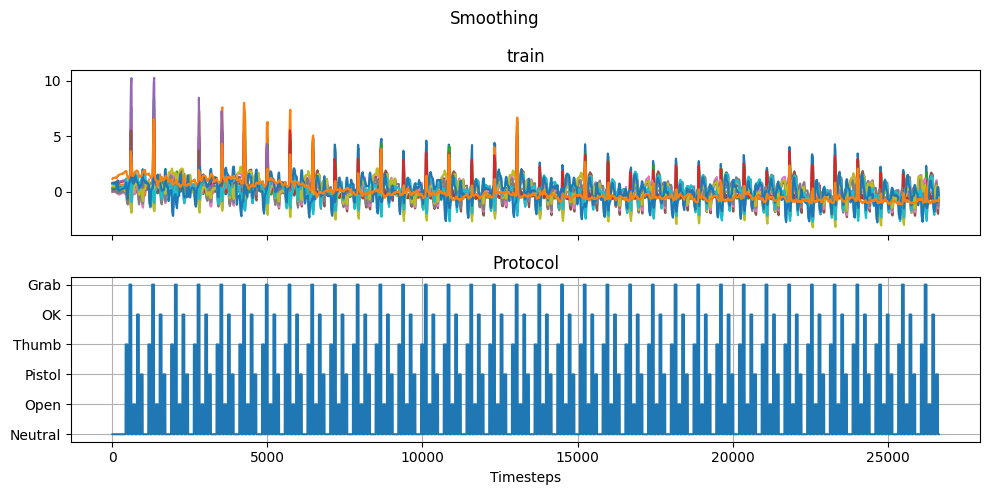

In [125]:
#A smaller alpha gives more weight to older observations, while a larger alpha emphasizes newer observations

alpha = 0.1 #0.006

# Apply exponential smoothing to each feature column

def smooth(df):
  alpha = 0.1
  df = pd.DataFrame(df)
  X_smoothed = pd.DataFrame()
  for column in df.columns:
      smoothed_values = [df[column].iloc[0]]  # Initialize with the first observed value
      for i in range(1, len(df)):
          smoothed_value = alpha * df[column].iloc[i] + (1 - alpha) * smoothed_values[-1]
          smoothed_values.append(smoothed_value)
      X_smoothed[column] = smoothed_values
  return X_smoothed

df_smoothed = smooth(df_selected_scaled)

fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(df_smoothed.values)
plt.title('train')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('Smoothing')
plt.tight_layout()

## Study of time delay

In [126]:
'''
temp = df_smoothed.copy()
cols = temp.columns
temp[cols] = temp[cols].apply(lambda x: np.abs(x))
temp['disp'] = temp[cols].sum(axis=1)

num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
short=temp[:1000]
y_short = y_cmd[:1000]
cols = short.columns
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        start_index = 12 + (i * num_cols + j)
        df = short[cols].shift(-start_index)
        df['gesture'] = pd.Series(y_short)
        df.fillna(0, inplace=True)

        ax2 = ax.twinx()

        ax.plot(df.index, df['disp'], label='disp', color='tab:blue')
        ax.set_ylabel('disp', color='tab:blue')

        ax2.plot(df.index, df['gesture'], label='gesture', linestyle='--', color='tab:red')
        ax2.set_ylabel('gesture', color='tab:red')

        ax.set_title(f'Data from index {start_index}')

        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
'''

"\ntemp = df_smoothed.copy()\ncols = temp.columns\ntemp[cols] = temp[cols].apply(lambda x: np.abs(x))\ntemp['disp'] = temp[cols].sum(axis=1)\n\nnum_rows = 3\nnum_cols = 2\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))\nshort=temp[:1000]\ny_short = y_cmd[:1000]\ncols = short.columns\nfor i, ax_row in enumerate(axes):\n    for j, ax in enumerate(ax_row):\n        start_index = 12 + (i * num_cols + j)\n        df = short[cols].shift(-start_index)\n        df['gesture'] = pd.Series(y_short)\n        df.fillna(0, inplace=True)\n\n        ax2 = ax.twinx()\n\n        ax.plot(df.index, df['disp'], label='disp', color='tab:blue')\n        ax.set_ylabel('disp', color='tab:blue')\n\n        ax2.plot(df.index, df['gesture'], label='gesture', linestyle='--', color='tab:red')\n        ax2.set_ylabel('gesture', color='tab:red')\n\n        ax.set_title(f'Data from index {start_index}')\n\n        ax.legend(loc='upper left')\n        ax2.legend(loc='upper right')\n\nplt.tight_layout()\n

In [127]:
'''
def shift(df, y_cmd):
    cor_list = {}
    temp = df.apply(lambda x: np.abs(x))
    cols = df.columns
    temp['disp'] = temp[cols].sum(axis=1)
    for shift_value in range(0, 30, 1):
        shifted_y = y_cmd.shift(shift_value)
        shifted_y.fillna(0, inplace=True)
        correlation = temp['disp'].corr(pd.Series(shifted_y))
        cor_list[shift_value] = correlation

    max_correlation_shift = max(cor_list, key=cor_list.get)
    print(max_correlation_shift)

    shifted_y = y_cmdy_cmd.shift(max_correlation_shift)
    temp_short = temp[:1000]
    y_short = shifted_y[:1000]
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax2 = ax.twinx()
    ax.plot(shifted_temp.index, shifted_temp['disp'], label='disp', color='tab:blue')
    ax.set_ylabel('disp', color='tab:blue')
    ax2.plot(shifted_temp.index, y_short, label='gesture', linestyle='--', color='tab:red')
    ax2.set_ylabel('gesture', color='tab:red')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    df_shifted = df.shift(max_correlation_shift)
    df_shifted.fillna(0, inplace=True)
    return df_shifted


df_shifted = shift(df_smoothed, y_cmd)
'''

"\ndef shift(df, y_cmd):\n    cor_list = {}\n    temp = df.apply(lambda x: np.abs(x))\n    cols = df.columns\n    temp['disp'] = temp[cols].sum(axis=1)\n    for shift_value in range(0, 30, 1):\n        shifted_y = y_cmd.shift(shift_value)\n        shifted_y.fillna(0, inplace=True)\n        correlation = temp['disp'].corr(pd.Series(shifted_y))\n        cor_list[shift_value] = correlation\n\n    max_correlation_shift = max(cor_list, key=cor_list.get)\n    print(max_correlation_shift)\n\n    shifted_y = y_cmdy_cmd.shift(max_correlation_shift)\n    temp_short = temp[:1000]\n    y_short = shifted_y[:1000]\n    fig, ax = plt.subplots(1, 1, figsize=(6, 3))\n    ax2 = ax.twinx()\n    ax.plot(shifted_temp.index, shifted_temp['disp'], label='disp', color='tab:blue')\n    ax.set_ylabel('disp', color='tab:blue')\n    ax2.plot(shifted_temp.index, y_short, label='gesture', linestyle='--', color='tab:red')\n    ax2.set_ylabel('gesture', color='tab:red')\n    ax.legend(loc='upper left')\n    ax2.legen

## Median of previous ts


In [ ]:
'''
median_ts_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)


cols = median_ts_df.columns[:df_shifted.shape[1]]
for i in cols:
    median_ts_df.rename(columns={i: f'col_0_{i}'}, inplace=True)


median_ts_df.fillna(median_ts_df.median(), inplace=True)


for n in range(len(median_ts_df)):
    for i in cols:
        median_ts_df.loc[n, f'col_{i}_median'] = median_ts_df.loc[n, [f'col_{j}_{i}' for j in range(1, 10)]].median()

cols_0 = [f'col_0_{i}' for i in cols]
cols_med = [f'col_{i}_median' for i in cols]

median_ts_df = median_ts_df[cols_0 + cols_med]
median_ts_df.head()
'''

# Split

In [128]:
X_train = df_smoothed.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = df_smoothed.values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20756, 12) (20756,)
(5892, 12) (5892,)


In [129]:
display(pd.Series(y_train).value_counts(),
        pd.Series(y_test).value_counts())

0    12287
2     1696
5     1694
1     1694
3     1693
4     1692
dtype: int64

0    3483
1     486
3     484
2     482
5     479
4     478
dtype: int64

## Remove outliers


(20756, 13)


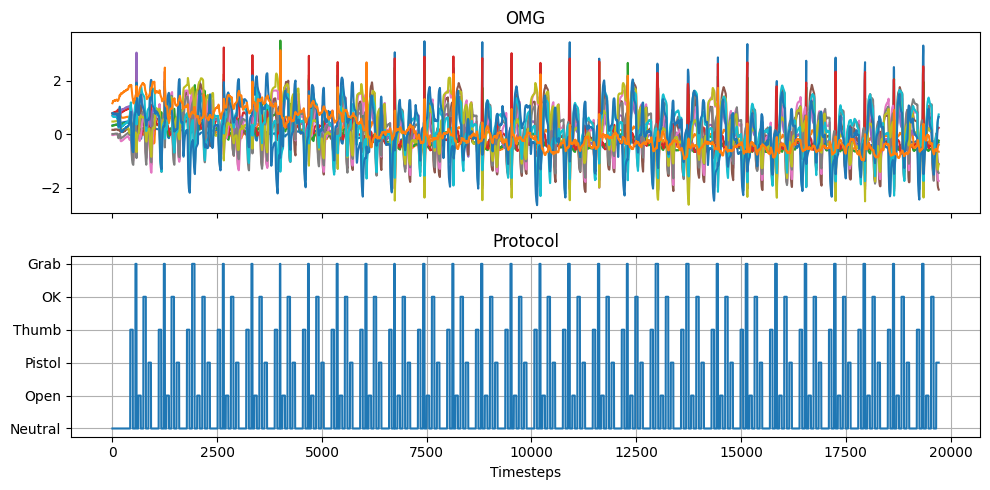

In [152]:

#PyOD unsupervised outlier detection models: kNN, Isolation Forest, Local Outlier Factor (LOF),
#Cluster-based Local Outlier Factor (CBLOF),Histogram-based Outlier Detection (HBOS)
#scores: ROC AUC Score,Precision-Recall Curve,Outlier Detection Accuracy,Silhouette Score,Visual Inspection and Domain Knowledge
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

df_full_train = pd.DataFrame(X_train)
cols=df_full_train.columns
df_full_train['gestures'] = pd.Series(y_train)
print(df_full_train.shape)
def outliers(df, model):
    detector = model
    detector.fit(df)
    outlier_scores = detector.decision_scores_  # Use decision_scores_ instead of predict
    threshold = np.percentile(outlier_scores, 95)  # Example threshold (adjust as needed) # delete 1%
    outlier_indices = np.where(outlier_scores > threshold)[0]  # Get indices of outliers
    mask = ~df.index.isin(outlier_indices)
    df_filtered = df.iloc[outlier_indices]
    df_filtered = df[mask]
    return df_filtered

temp = outliers(df_full_train, IForest())

fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(temp[cols].values)
plt.title('OMG')

plt.sca(axx[1])
temp1 = temp.reset_index()
plt.plot(temp1['gestures'])
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.tight_layout()

plt.show()


X_train_clean = temp.drop('gestures', axis=1)
y_train_clean = temp['gestures']


## Optbinning

In [157]:
'''
import optbinning
from optbinning import BinningProcess

binning_process = optbinning.BinningProcess(variable_names=list(X_train_clean.columns),
                                              max_n_prebins=20,
                                              min_prebin_size=0.05,
                                              min_n_bins=None,
                                              max_n_bins=None,
                                              min_bin_size=None,
                                              max_bin_size=None,
                                              max_pvalue=None,
                                              max_pvalue_policy='consecutive',
                                              selection_criteria=None,
                                              fixed_variables=None,
                                              categorical_variables=list(X_train_clean.columns),
                                              special_codes=None,
                                              split_digits=None,
                                              binning_fit_params=None,
                                              binning_transform_params=None,
                                              n_jobs=None,
                                              verbose=False)


binning_process.fit(X_train_clean, y_train_clean)

X_binned = binning_process.transform(X_train_clean)

fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(X_binned.values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_clean)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()
'''

(CVXPY) Mar 19 08:32:56 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 19 08:32:56 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


TypeError: variables in categorical_variables must be strings.

## Smote

In [131]:
from imblearn.over_sampling import SMOTE
display(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42, sampling_strategy='auto',k_neighbors=5)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
pd.Series(y_resampled).value_counts()

0    12287
2     1696
5     1694
1     1694
3     1693
4     1692
dtype: int64

0    12287
3    12287
5    12287
1    12287
4    12287
2    12287
dtype: int64

# Training

## Boosting

[I 2024-03-19 06:37:16,591] A new study created in memory with name: no-name-d82b1881-26c8-4601-b866-f537775f6873
<ipython-input-132-1a328ea9188a>:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-03-19 06:37:28,199] Trial 0 finished with value: 0.5295315682281059 and parameters: {'iterations': 48, 'learning_rate': 0.0981733422044693, 'depth': 6}. Best is trial 0 with value: 0.5295315682281059.
[I 2024-03-19 06:37:51,323] Trial 1 finished with value: 0.47216564833672775 and parameters: {'iterations': 38, 'learning_rate': 0.002631240327156049, 'depth': 9}. Best is trial 0 with value: 0.5295315682281059.
[I 2024-03-19 06:38:11,353] Trial 2 finished with value: 0.45095044127630685 and parameters: {'iterations': 24, 'learning_rate': 0.03366375577540973, 'depth': 10}. Best is trial 0 with value: 0.5295315682281059.
[I 2024-0

Best parameters: {'iterations': 52, 'learning_rate': 0.09822929546670402, 'depth': 7}
              precision    recall  f1-score   support

           0       0.79      0.46      0.58      3483
           1       0.53      0.77      0.63       486
           2       0.31      0.56      0.40       482
           3       0.40      0.82      0.53       484
           4       0.46      0.74      0.57       478
           5       0.61      0.70      0.65       479

    accuracy                           0.56      5892
   macro avg       0.52      0.67      0.56      5892
weighted avg       0.66      0.56      0.57      5892



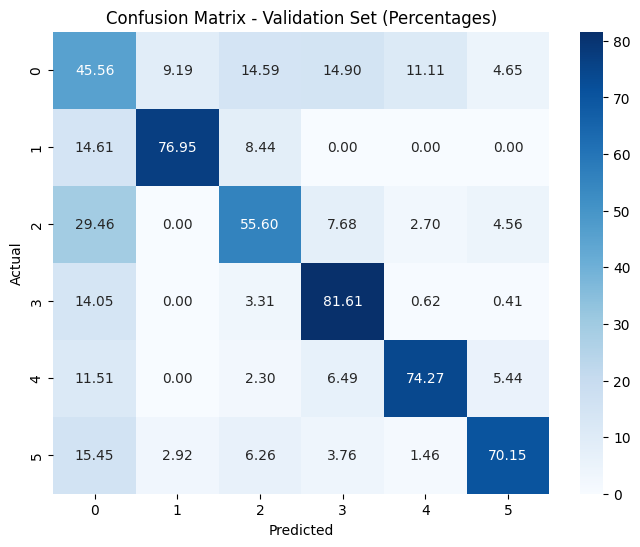

In [132]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        # Add more hyperparameters to optimize as needed
    }

    # Initialize CatBoost classifier with suggested parameters
    model = CatBoostClassifier(**params, eval_metric='Accuracy', verbose=False)

    # Fit the model to the training data
    model.fit(X_resampled, y_resampled,
          eval_set=(X_test, y_test), early_stopping_rounds=100)

    # Evaluate the model's performance on the validation set
    accuracy = model.best_score_['validation']['Accuracy']
    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Since we want to minimize the negative accuracy
study.optimize(objective, n_trials=20)

# Retrieve the best parameters found by Optuna
best_params = study.best_params
print("Best parameters:", best_params)

# Initialize CatBoost with the best parameters and train with early stopping
model = CatBoostClassifier(**best_params, eval_metric='Accuracy', verbose=False)
model.fit(X_resampled, y_resampled,
          eval_set=(X_test, y_test),
          early_stopping_rounds=100)

# Predict on the test set and evaluate performance
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

In [133]:
y_pred = model.predict(X_test[0])

              precision    recall  f1-score   support

     Neutral       0.76      0.66      0.70      3483
        Open       0.66      0.71      0.68       486
      Pistol       0.27      0.54      0.36       482
       Thumb       0.55      0.59      0.57       484
          OK       0.57      0.50      0.53       478
        Grab       0.75      0.70      0.72       479

    accuracy                           0.64      5892
   macro avg       0.59      0.62      0.59      5892
weighted avg       0.68      0.64      0.65      5892



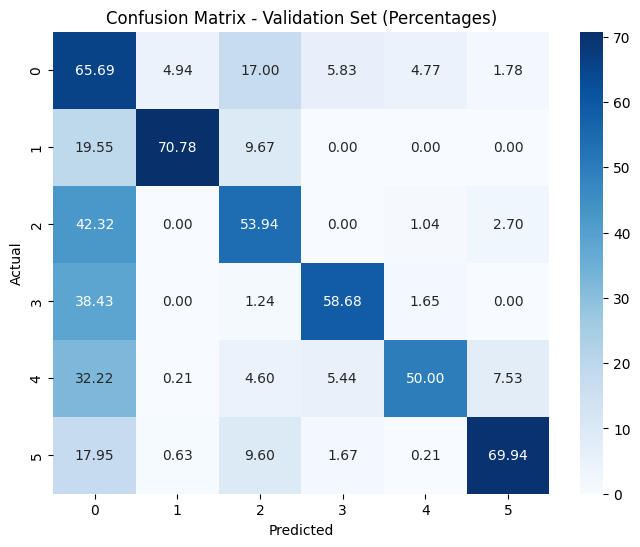

In [134]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier with the specified parameters
model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=30)

# Fit the model to the training data
model_boost.fit(X_resampled, y_resampled, eval_set=(X_test, y_test))

# Predict on the test set and evaluate performance
y_pred = model_boost.predict(X_test)
print(classification_report(y_test, y_pred, target_names=GESTURES))

cm = confusion_matrix(y_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()


## 2 step classification

              precision    recall  f1-score   support

           0       0.72      0.48      0.57      3483
           1       0.49      0.74      0.59      2409

    accuracy                           0.58      5892
   macro avg       0.61      0.61      0.58      5892
weighted avg       0.63      0.58      0.58      5892



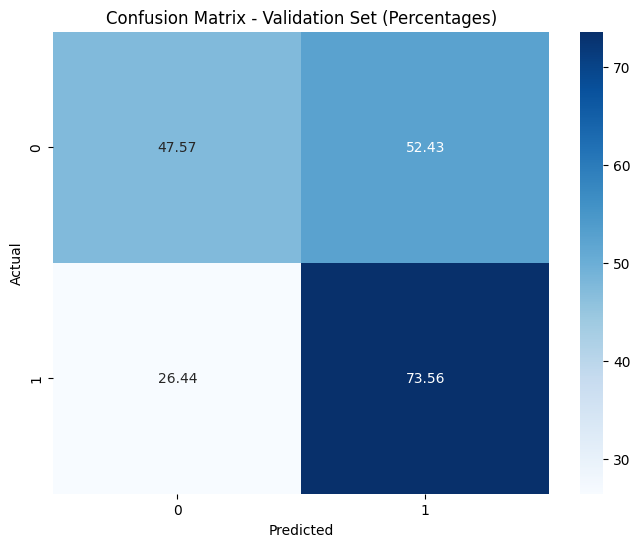

In [135]:
# 0 vs others
y_bin_train = pd.Series(y_resampled).apply(lambda x: 0 if x==0 else 1)
y_bin_test = pd.Series(y_test).apply(lambda x: 0 if x==0 else 1)

n_estimators = 100
max_depth = 10
min_samples_split = 2
min_samples_leaf = 3
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf
)
model_rf.fit(X_resampled, y_bin_train)
y_pred = model_rf.predict(X_test)
print(classification_report(y_bin_test, y_pred))

cm = confusion_matrix(y_bin_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_bin_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

              precision    recall  f1-score   support

           1       0.95      0.81      0.87       486
           2       0.64      0.51      0.57       482
           3       0.68      0.84      0.75       484
           4       0.83      0.83      0.83       478
           5       0.77      0.86      0.81       479

    accuracy                           0.77      2409
   macro avg       0.77      0.77      0.77      2409
weighted avg       0.77      0.77      0.77      2409



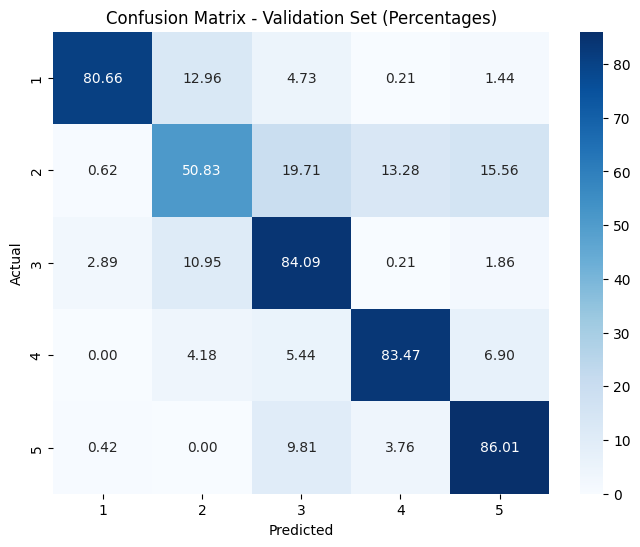

In [136]:
non_zero_indices_train = y_resampled != 0
non_zero_indices_test = y_test != 0

y_gest_train = y_resampled[non_zero_indices_train]
y_gest_test = y_test[non_zero_indices_test]
X_gest_train = X_resampled[non_zero_indices_train]
X_gest_test = X_test[non_zero_indices_test]

model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=50)

# Fit the model to the training data
model_boost.fit(X_gest_train, y_gest_train, eval_set=(X_gest_test, y_gest_test))

# Predict on the test set and evaluate performance
y_pred = model_boost.predict(X_gest_test)
print(classification_report(y_gest_test, y_pred))

cm = confusion_matrix(y_gest_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_gest_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

              precision    recall  f1-score   support

           0       0.72      0.48      0.57      3483
           1       0.42      0.69      0.52       486
           2       0.21      0.42      0.28       482
           3       0.46      0.54      0.49       484
           4       0.44      0.71      0.55       478
           5       0.55      0.61      0.58       479

    accuracy                           0.52      5892
   macro avg       0.47      0.57      0.50      5892
weighted avg       0.60      0.52      0.54      5892



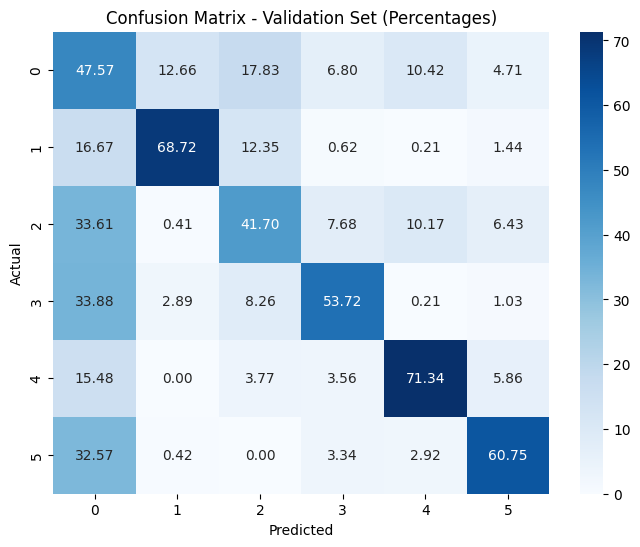

In [137]:
def double_check(x):
  y_pred_bin = model_rf.predict(x)
  zero_indices = np.where(y_pred_bin == 0)[0]
  non_zero_indices = np.where(y_pred_bin != 0)[0]

  x_gest = x[non_zero_indices]
  y_pred_gest = model_boost.predict(x_gest).reshape(-1)

  y_pred_bin[non_zero_indices] = y_pred_gest

  return y_pred_bin

y_pred = double_check(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3483
           3       0.74      0.41      0.53       484

    accuracy                           0.91      3967
   macro avg       0.83      0.69      0.74      3967
weighted avg       0.90      0.91      0.90      3967



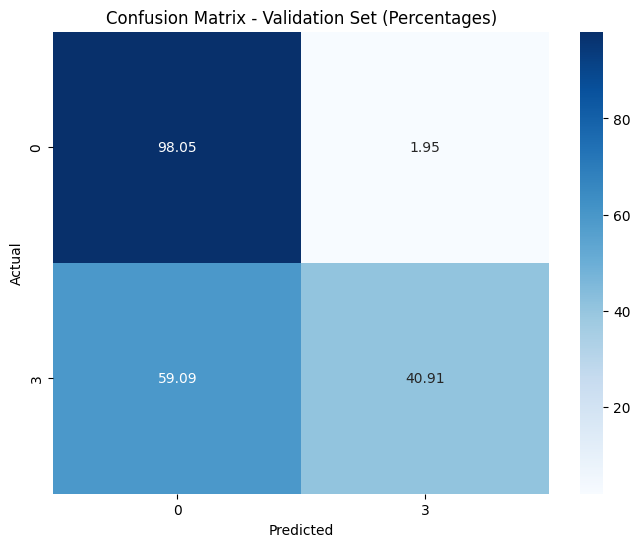

In [138]:
# 0 vs 3

ind_train = (y_resampled == 0) | (y_resampled == 3)
ind_test = (y_test == 0) | (y_test == 3)

y_bin_train = y_resampled[ind_train]
y_bin_test = y_test[ind_test]
X_bin_train = X_resampled[ind_train]
X_bin_test = X_test[ind_test]

n_estimators = 100
max_depth = 10
min_samples_split = 2
min_samples_leaf = 3
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf
)
model_rf.fit(X_bin_train, y_bin_train)
y_pred = model_rf.predict(X_bin_test)
print(classification_report(y_bin_test, y_pred))

cm = confusion_matrix(y_bin_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_bin_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

## Study of neutral and thumb

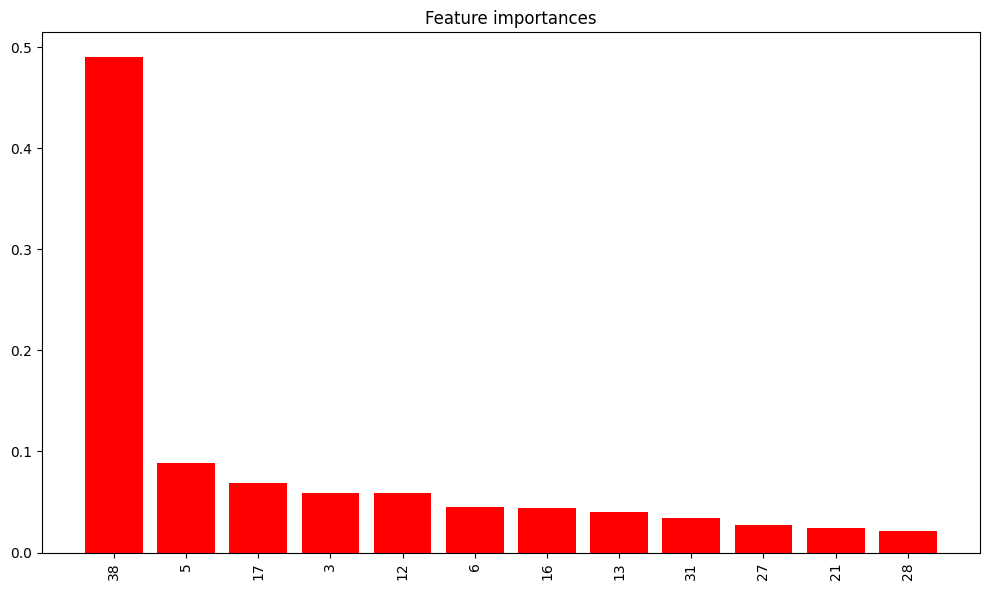

In [139]:
indx = (y_cmd == 0) | (y_cmd == 3)
df_indx = df_selected[indx]
y_indx = y_cmd[indx]

X_train, X_test, y_train, y_test = train_test_split(df_indx, y_indx, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(
    max_depth=48,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features=0.71,
    random_state=42
)
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = df_indx.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

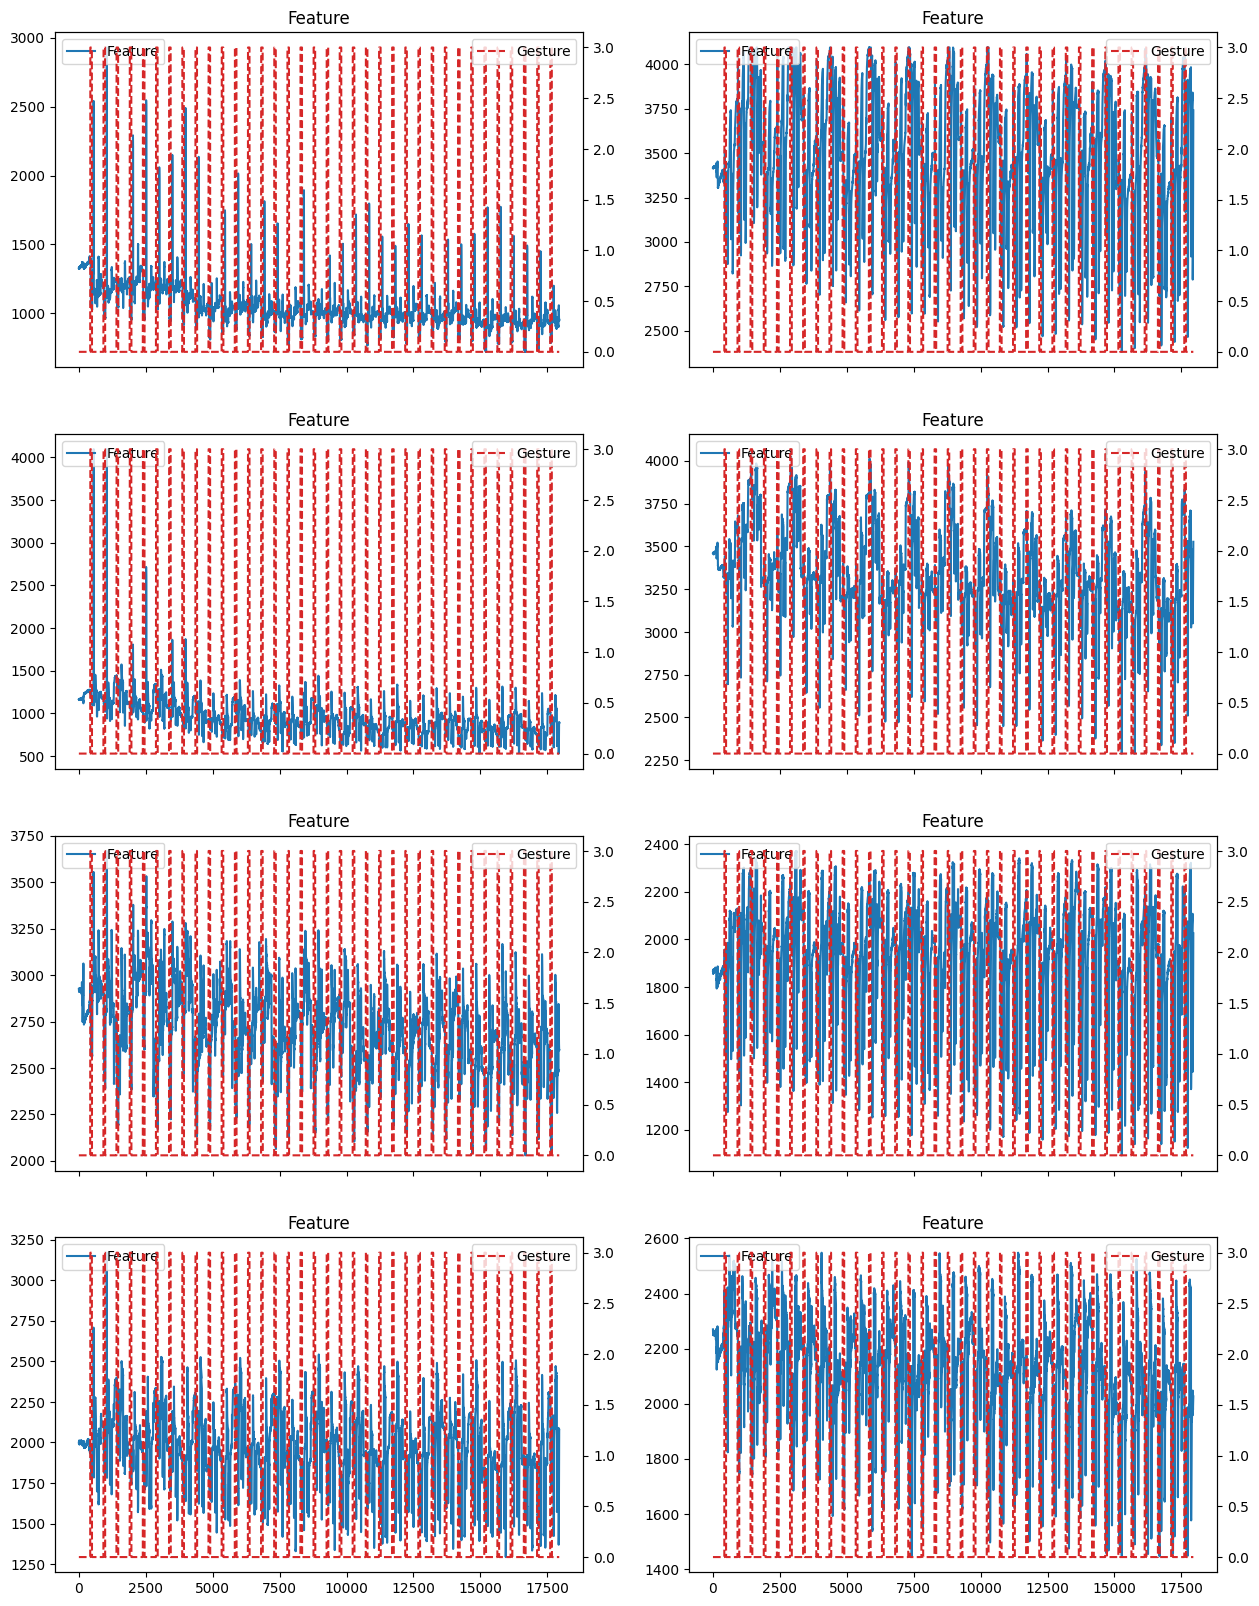

In [140]:
cols = feature_names[indices]

fig, axx = plt.subplots(4, 2, sharex=True, figsize=(15, 20))

for i in range(5):
    for j in range(2):
        # Calculate the column index
        col_index = i * 2 + j

        if col_index < len(cols):
            ax = axx[i, j]
            ax2 = ax.twinx()

            ax.plot(df_indx[cols[col_index]].values, color='tab:blue', label='Feature')
            ax.set_title('Feature')

            ax2.plot(y_indx, linestyle='--', color='tab:red', label='Gesture')

            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


In [ ]:
'''
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tsfresh.feature_extraction import MinimalFCParameters

indx = (y_cmd == 0) | (y_cmd == 3)
df_indx = df_shifted[indx]
y_indx = y_cmd[indx]

df_indx['ts'] = gestures['ts'][indx]
fc_parameters = MinimalFCParameters()

window_size = 10
step_size = 1
df_windowed = pd.concat([df_indx[i:i+window_size] for i in range(0, len(df_indx) - window_size + 1, step_size)], ignore_index=True)

def impute(X):
    column_means = X.mean()
    X_imputed = X.fillna(column_means)
    return X_imputed

# Extract features
df_features = extract_features(df_windowed, column_id='ts', default_fc_parameters=fc_parameters,
                               impute_function=impute, show_warnings=False, n_jobs=4)
display(df_features.head(),
        df_features.shape)
'''

In [ ]:
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, y_indx, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(
    max_depth=48,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features=0.71,
    random_state=42
)
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = df_features.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
'''

## LSTM

### 3d ds

In [141]:
new_df = pd.concat([df_smoothed] + [df_smoothed.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)

cols = new_df.columns[:df_smoothed.shape[1]]
for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)

new_df.fillna(new_df.median(), inplace=True)

In [142]:
n_columns = len(df_smoothed.columns)
n_shift = 10
reshaped_array = new_df.to_numpy().reshape(new_df.shape[0], n_columns, n_shift)[:,::-1,:]

X_train_3d = reshaped_array[:last_train_idx]
y_train_2d= y_cmd[:last_train_idx]

X_test_3d  = reshaped_array[last_train_idx:]
y_test_2d = y_cmd[last_train_idx:]

from keras.utils import to_categorical
y_train_2d = to_categorical(y_train_2d)
y_test_2d = to_categorical(y_test_2d)

display(X_train_3d.shape,
        y_train_2d.shape)
display(X_test_3d.shape,
        y_test_2d.shape)

(20756, 12, 10)

(20756, 6)

(5892, 12, 10)

(5892, 6)

In [ ]:
def plot_accur(history, epochs=20):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### lstm

In [143]:
n_columns = len(df_smoothed.columns)
n_shift = 10
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(n_columns,n_shift)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(len(np.unique(y_cmd)), activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_3d, y_train_2d,
                               epochs=40,
                               batch_size=32,
                               validation_data=(X_test_3d, y_test_2d),
                              verbose=0)

# Model Evaluation
y_pred = model_lstm.predict(X_test_3d)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test_2d, axis=1), y_pred_classes, target_names=GESTURES))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test_2d, axis=1), y_pred_classes)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

185/185 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

     Neutral       0.85      0.75      0.80      3483
        Open       0.78      0.43      0.55       486
      Pistol       0.45      0.61      0.52       482
       Thumb       0.61      0.80      0.69       484
          OK       0.76      0.77      0.77       478
        Grab       0.51      0.86      0.64       479

    accuracy                           0.73      5892
   macro avg       0.66      0.70      0.66      5892
weighted avg       0.76      0.73      0.73      5892



ValueError: Shape of passed values is (6, 6), indices imply (2, 2)

### lstm + biderectional

In [145]:
from keras.layers import Bidirectional

# Define the model
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(64), input_shape=(n_columns,n_shift)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(len(np.unique(y_cmd)), activation='softmax'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_lstm = model_lstm.fit(X_train_3d, y_train_2d,
                               epochs=30,
                               batch_size=32,#
                               validation_data=(X_test_3d, y_test_2d),
                               verbose=0)

# Model Evaluation
y_pred = model_lstm.predict(X_test_3d)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test_2d, axis=1), y_pred_classes, target_names=GESTURES))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test_2d, axis=1), y_pred_classes)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

185/185 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

     Neutral       0.84      0.67      0.75      3483
        Open       0.54      0.67      0.60       486
      Pistol       0.53      0.54      0.54       482
       Thumb       0.67      0.63      0.65       484
          OK       0.61      0.84      0.71       478
        Grab       0.49      0.90      0.64       479

    accuracy                           0.69      5892
   macro avg       0.61      0.71      0.65      5892
weighted avg       0.73      0.69      0.70      5892



ValueError: Shape of passed values is (6, 6), indices imply (2, 2)

### combination

In [149]:
display(X_train_3d.shape,
        y_train_2d.shape)
display(X_test_3d.shape,
        y_test_2d.shape)

X_train = df_smoothed.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = df_smoothed.values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

display(X_train.shape, y_train.shape,
        X_test.shape, y_test.shape)

(20756, 12, 10)

(20756, 6)

(5892, 12, 10)

(5892, 6)

(20756, 12)

(20756,)

(5892, 12)

(5892,)

In [150]:
from keras.layers import Input, LSTM, Dense, Bidirectional, concatenate, Flatten
from keras.models import Model
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Define input shape for LSTM model
input_lstm = Input(shape=(n_columns, n_shift))
lstm_output = Bidirectional(LSTM(64))(input_lstm)
dense_layer_lstm = Dense(64, activation='relu')(lstm_output)

# Define the general feedforward network
n_cols = len(df_smoothed.columns)
input_ffn = Input(shape=(n_cols, ))
flatten_layer_ffn = Flatten()(input_ffn)
dense_layer_ffn1 = Dense(32, activation='relu')(flatten_layer_ffn)
dense_layer_ffn2 = Dense(64, activation='relu')(dense_layer_ffn1)
dense_layer_ffn3 = Dense(128, activation='relu')(dense_layer_ffn2)

# Concatenate the outputs of LSTM and feedforward networks
merged = concatenate([dense_layer_lstm, dense_layer_ffn3])

# Add additional layers if needed
dense_layer_merged = Dense(128, activation='relu')(merged)

# Output layer
output = Dense(len(np.unique(y_cmd)), activation='softmax')(dense_layer_merged)

# Define the combined model
combined_model = Model(inputs=[input_lstm, input_ffn], outputs=output)

# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
combined_model.summary()

# Fit the model
combined_model.fit([X_train_3d, X_train],
                   y_train_2d, epochs=30, batch_size=32,
                   validation_data=([X_test_3d, X_test], y_test_2d),
                   verbose=0)

# Calculate F1 score for training data
y_pred_train_probs = combined_model.predict([X_train_3d, X_train], verbose=0)
y_pred_train_classes = np.argmax(y_pred_train_probs, axis=1)
f1_train = f1_score(np.argmax(y_train_2d, axis=1), y_pred_train_classes, average='weighted')

# Calculate F1 score for testing data
y_pred_test_probs = combined_model.predict([X_test_3d, X_test], verbose=0)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
f1_test = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')

# Print F1 scores
print("F1 score for training data:", f1_train)
print("F1 score for testing data:", f1_test)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 12)                   0         ['input_5[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 12, 10)]             0         []                            
                                                                                                  
 dense_18 (Dense)            (None, 32)                   416       ['flatten_1[0][0]']           
                                                                                            

In [ ]:
x_test = gestures.values[last_train_idx:][0]
y_test = y_cmd[last_train_idx:][0]

x_proc = preprocessing(gestures, gestures_protocol)
y_pred_test_probs = combined_model.predict([X_test_3d, X_test], verbose=0)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
f1_test = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')

## Legendre Memory Unit (LMU)

In [151]:
pip install keras-lmu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras_lmu import LMUCell, LMU
from tensorflow.keras.models import Model


# Define LMU parameters
sequence_length = X_train_3d.shape[1]
num_features = X_train_3d.shape[2]
memory_size = 128  # Number of memory units in the LMU
theta = 10  # Length scale parameter for Legendre polynomials
order = 2  # Order of Legendre polynomial approximation
hidden_cell = tf.keras.layers.SimpleRNNCell(128)  # Hidden cell for the LMU

# Define LMU cell
lmu_cell = LMUCell(memory_size, order=order, theta=theta, hidden_cell=hidden_cell)

# Define input layer
inputs = Input(shape=(sequence_length, num_features))

# Create LMU layer
lmu_layer = LMU(lmu_cell, order=order, theta=theta, hidden_cell=hidden_cell, return_sequences=True)(inputs)

# Add output layer for classification/regression, for example:
outputs = Dense(1, activation='sigmoid')(lmu_layer)  # Example output layer for binary classification

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_3d, y_train_2d, epochs=10, batch_size=32, validation_data=(X_test_3d, y_test_2d))


# Calculate F1 score for training data
y_pred_train_probs = model.predict(X_train_3d, verbose=0)
y_pred_train_classes = np.argmax(y_pred_train_probs, axis=1)
f1_train = f1_score(np.argmax(y_train_2d, axis=1), y_pred_train_classes, average='weighted')

# Calculate F1 score for testing data
y_pred_test_probs = model.predict(X_test_3d, verbose=0)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
f1_test = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')

# Print F1 scores
print("F1 score for training data:", f1_train)
print("F1 score for testing data:", f1_test)


In [ ]:
# Model Evaluation
y_pred = model.predict(X_test_3d)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test_2d, y_pred_classes, target_names=GESTURES))

# Confusion Matrix
cm = confusion_matrix(y_test_2d, y_pred_classes)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()


## sparkling neural network

## Attention Mechanism

In [158]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, Activation, Permute, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score


def RNNAttentionModel(input_size, hid_size, rnn_type, bidirectional, n_classes=6, kernel_size=5):
    input_layer = Input(shape=input_size)  # Corrected the shape parameter here
    print('input', input_layer.shape)
    # RNN layer
    if rnn_type == 'LSTM':
        rnn_layer = LSTM(hid_size,return_sequences=True)
    elif rnn_type == 'GRU':
        rnn_layer = GRU(hid_size,return_sequences=True)
    else:
        raise ValueError("Invalid RNN type. Please choose 'LSTM' or 'GRU'.")

    if bidirectional:
        rnn_layer = Bidirectional(rnn_layer)

    #x = Conv1D(hid_size, kernel_size, padding='same')(input_layer)
    #x = Conv1D(hid_size, kernel_size, padding='same')(x)

    # Apply RNN
    x_out = rnn_layer(input_layer)
    print('out',x_out.shape)

    # Attention mechanism
    attn = Dense(hid_size*2, activation='tanh')(x_out)
    print('attn',attn.shape)
    #attn = Permute((2, 1))(attn)

    attn = Multiply()([x_out, attn])
    # Global Attention
    attn = Lambda(lambda x: K.mean(x, axis=1))(attn)

    # Output layer
    output = Dense(n_classes, activation='softmax')(attn)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Define model
hid_size = 64  # You need to define this variable
input_size=(n_shift,n_columns)
model = RNNAttentionModel(input_size=input_size, hid_size=hid_size, rnn_type='LSTM', bidirectional=True, n_classes=6, kernel_size=5)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_3d, y_train_2d,
          epochs=30,
          batch_size=32,
          validation_data=(X_test_3d, y_test_2d),
          verbose=0)

# Calculate F1 score for training data
y_pred_train_probs = model.predict(X_train_3d, verbose=0)
y_pred_train_classes = np.argmax(y_pred_train_probs, axis=1)
f1_train = f1_score(np.argmax(y_train_2d, axis=1), y_pred_train_classes, average='weighted')

# Calculate F1 score for testing data
y_pred_test_probs = model.predict(X_test_3d, verbose=0)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
f1_test = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')

# Print F1 scores
print("F1 score for training data:", f1_train)
print("F1 score for testing data:", f1_test)


input (None, 10, 12)
out (None, 10, 128)
attn (None, 10, 128)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 10, 12), found shape=(None, 12, 10)


F1 score for training data: 0.9848894710284501

F1 score for testing data: 0.8424452496102519

## Optimization of parameters with ts fresh

In [ ]:
'''
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
df = gestures[OMG_CH].copy()
df['artificial_index'] = range(len(df))

df_features = extract_features(df, column_id="artificial_index")

# Drop the artificial index column if you don't need it anymore
df.drop('artificial_index', axis=1, inplace=True)
df_features.shape
'''

In [ ]:
'''
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

X_train = df.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = df.values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

model = DecisionTreeClassifier(
    max_depth=48,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features=0.71,
    random_state=42
)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = df.columns
cols = feature_names[indices][:12]
display(cols)
df_selected = df[cols]

cor_list = {}

for shift_value in range(0, -20, -1):
    temp = df_selected.copy()
    cols = df_selected.columns
    scaler = StandardScaler()
    temp_scaled = scaler.fit_transform(temp)  # Changed X to temp
    temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)  # Changed X to temp
    scaled_temp = temp_scaled_df.apply(lambda x: np.abs(x))  # Changed scaled_temp to temp_scaled_df
    scaled_temp['disp'] = scaled_temp[cols].sum(axis=1)
    shifted_temp = scaled_temp.shift(shift_value)
    shifted_temp.fillna(shifted_temp.median(), inplace=True)  # Added inplace=True to fillna
    correlation = shifted_temp['disp'].corr(pd.Series(y_cmd))
    cor_list[shift_value] = correlation

max_correlation_shift = max(cor_list, key=cor_list.get)

df_shifted = df_selected.shift(max_correlation_shift)
df_shifted.fillna(0, inplace=True)

new_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)

cols = new_df.columns[:df_shifted.shape[1]]
for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)

new_df.fillna(new_df.median(), inplace=True)

n_columns = len(imp_features)
n_shift = 10
reshaped_array = new_df.to_numpy().reshape(new_df.shape[0], n_columns, n_shift)[:,::-1,:]

X_train_3d = reshaped_array[:last_train_idx]
y_train_2d= y_cmd[:last_train_idx]

X_test_3d  = reshaped_array[last_train_idx:]
y_test_2d = y_cmd[last_train_idx:]

#scale
scaler = StandardScaler()
X_train_3d=scaler.fit_transform(X_train_3d.reshape(-1, X_train_3d.shape[-1])).reshape(X_train_3d.shape)
X_test_3d=scaler.transform(X_test_3d.reshape(-1, X_test_3d.shape[-1])).reshape(X_test_3d.shape)

from keras.utils import to_categorical
y_train_2d = to_categorical(y_train_2d)
y_test_2d = to_categorical(y_test_2d)

# Define the model
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(64), input_shape=(n_columns, n_shift)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(len(np.unique(y_cmd)), activation='softmax'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_lstm = model_lstm.fit(X_train_3d, y_train_2d,
                               epochs=30,
                               batch_size=32,#
                               validation_data=(X_test_3d, y_test_2d),
                               verbose=0)

# Calculate F1 score for training data
y_pred_train_probs = model_lstm.predict(X_train_3d, verbose=0)
y_pred_train_classes = np.argmax(y_pred_train_probs, axis=1)
f1_train = f1_score(np.argmax(y_train_2d, axis=1), y_pred_train_classes, average='weighted')

# Calculate F1 score for testing data
y_pred_test_probs = model_lstm.predict(X_test_3d, verbose=0)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
f1_test = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')

# Print F1 scores
print(f1_train, f1_test)
'''

## SVM

In [ ]:
svm_model = SVC(C=0.5, gamma='scale',kernel='linear',class_weight='balanced')
svm_model.fit(X_resampled, y_resampled)

y_pred = svm_model.predict(X_test)

print("Testing Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

## Stacking



In [ ]:
random_state=42
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    model.fit(X_train_pca, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_pca), average='weighted')

    return score

#study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
#study_rf.optimize(optuna_rf, n_trials=20)

#print("The best hyperparameters {}".format(study_rf.best_params))
#print("f1_score for train sample: {:.2f}".format(study_rf.best_value))


In [ ]:
def optuna_dt(trial):
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    model.fit(X_train_pca, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_pca), average='weighted')

    return score

#study_dt = optuna.create_study(study_name="DecisionTreeClassifier", direction="maximize")
#study_dt.optimize(optuna_dt, n_trials=20)

#print("The best hyperparameters {}".format(study_dt.best_params))
#print("f1_score for train sample: {:.2f}".format(study_dt.best_value))

In [ ]:
# rf:{'n_estimators': 114, 'max_depth': 30, 'min_samples_leaf': 2}
# dt:{'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.7121770779916502}
# took 2 mins
estimators = [
    ('dt',  DecisionTreeClassifier(
        **study_dt.best_params,
        random_state=42)),
    ('rf_opt', RandomForestClassifier(
        **study_rf.best_params,
        random_state=42)),
    ('log', LogisticRegression(
        random_state=42,
        solver = 'sag',
        max_iter=1000,
        penalty='l2'
    ))
]


reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
                                          random_state=42)
)

reg.fit(X_train_pca, y_train)
y_pred_train = reg.predict(X_train_pca)
y_pred_test = reg.predict(X_test_pca)
print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))


# Real-time inference

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  # Import display function
from sklearn.impute import SimpleImputer

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];

def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=30)

# Fit the model to the training data
model_boost.fit(X_resampled, y_resampled, eval_set=(X_test, y_test))

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

In [ ]:
sample = gestures.iloc[0, :]
[omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
omg_sample

In [ ]:
def smooth(df):
  alpha = 0.1
  df = pd.DataFrame(df)
  X_smoothed = pd.DataFrame()
  for column in df.columns:
      smoothed_values = [df[column].iloc[0]]  # Initialize with the first observed value
      for i in range(1, len(df)):
          smoothed_value = alpha * df[column].iloc[i] + (1 - alpha) * smoothed_values[-1]
          smoothed_values.append(smoothed_value)
      X_smoothed[column] = smoothed_values
  return X_smoothed

imp_features = [16, 28, 27, 39, 38, 3, 31, 13, 6, 22, 21, 17, 12, 30, 5] #for intersection of ds
imp_feat = [30, 21, 28, 31, 38, 17, 39, 12] # for studied ds

def preprocessing(x):
    '''
    if i have a list of 10 records
    new_x =np.concatenate(x) # получим датасет  из вида список на 10 элементов 50 датчиков в каждом -> 500 элементов
    new_x = imputer.transform(new_x.reshape(1,-1)) # dataset (10, 50)
    '''
    imp_feat = [30, 21, 28, 31, 38, 17, 39, 12]
    df = pd.DataFrame(x)
    # select important features
    df_selected = df.iloc[:,imp_feat]
    #scale
    df_selected_scaled = scaler.transform(df_selected)
    #smooth
    df_smoothed = smooth(df_selected_scaled)
    return df_smoothed

In [ ]:
def inference(x):
    y = model_boost.predict([x])
    return y

In [ ]:
def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

In [ ]:
# Reshape omg_sample to a 2D array
preprocessed_sample = preprocessing(omg_sample.values.reshape(1, -1))
display(preprocessed_sample.shape)

inference(preprocessed_sample)

In [ ]:
'''
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
y_dct['omg_sample'].append(omg_sample)
sample_preprocessed = preprocessing(y_dct['omg_sample'])[-n_lags:]

def inference(x):
    y_pred = model_boost.predict(x)
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y
'''

# Study of datasets and pilotes

In [ ]:
!git clone https://github.com/MaxBalashov/motorica-x-skillfactory-gestures.git

In [ ]:
df_meta = pd.read_csv('motorica-x-skillfactory-gestures/data/meta_information.csv', index_col=0)
display(df_meta.head(2),
        df_meta.info())


In [ ]:
bad = ['2023-05-15_17-12-24.palm', '2023-06-05_16-12-38.palm', '2023-10-18_08-05-29.palm', '2023-10-25_11-08-46.palm']
temp = df_meta[~df_meta['montage'].isin(bad)]


pilot1 = list(temp[temp['pilote_id'] == 1]['montage']) #2023-06-05_17-53-01.palm-test
pilot2 = list(temp[temp['pilote_id'] == 2]['montage']) #2023-09-12_14-59-23.palm,2023-09-12_12-55-22.palm,2023-09-13_22-14-05.palm - test
pilot3 = list(temp[temp['pilote_id'] == 3]['montage']) #2023-05-07_16-54-27.palm - test

In [ ]:
def read_omg_csv(path_palm_data: str,
                 n_omg_channels: int,
                 n_acc_channels: int = 0,
                 n_gyr_channels: int = 0,
                 n_mag_channels: int = 0,
                 n_enc_channels: int = 0,
                 button_ch: bool = True,
                 sync_ch: bool = True,
                 timestamp_ch: bool = True) -> pd.DataFrame:

    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''

    df_raw = pd.read_csv(path_palm_data, sep=' ',
                         header=None,
                         skipfooter=1,
                         skiprows=1,
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()

    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'],
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]

    if button_ch:
        columns = columns + ['BUTTON']

    if sync_ch:
        columns = columns + ['SYNC']

    if timestamp_ch:
        columns = columns + ['ts']

    df_raw.columns = columns

    return df_raw

## general model

### nn

In [ ]:
def make_y(gestures, gestures_protocol):
  OMG_CH = [str(i) for i in range(50)]
  le = LabelEncoder()
  # FIT
  le.fit(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )

  # TRANSFORM
  gestures_protocol['gesture'] = le.transform(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )
  y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
  return y_cmd

In [ ]:
def smooth(df):
  alpha = 0.1
  df = pd.DataFrame(df)
  X_smoothed = pd.DataFrame()
  for column in df.columns:
      smoothed_values = [df[column].iloc[0]]  # Initialize with the first observed value
      for i in range(1, len(df)):
          smoothed_value = alpha * df[column].iloc[i] + (1 - alpha) * smoothed_values[-1]
          smoothed_values.append(smoothed_value)
      X_smoothed[column] = smoothed_values
  return X_smoothed

def preprocessing(x, scaler):
    df_smoothed = smooth(x)  # Pass the input variable 'x' instead of 'df_selected'
    array_scaled = scaler.fit_transform(x)  # Use 'x' for scaling
    df_scaled = pd.DataFrame(array_scaled)
    return df_scaled

def imp_features(df, y):
    OMG_CH = [str(i) for i in range(50)]
    df['gest'] = pd.Series(y)
    df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
    std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
    std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
    imp_features_list = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
    df_selected = df[imp_features_list]
    return df_selected,imp_features_list

def d3_ds(df,y):
  # add previous timesteps values
  new_df = pd.concat([df] + [df.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
  cols = new_df.columns[:df.shape[1]]
  for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
  new_df.fillna(new_df.median(), inplace=True)
  n_columns = len(cols)
  n_shift = 10
  df_3d = new_df.to_numpy().reshape(new_df.shape[0], n_columns, n_shift)[:,::-1,:]

  y_2d = to_categorical(y)
  return df_3d, y_2d

In [ ]:
def lstm(X_train, y_train, X_test, y_test):
  n_columns = X_train.shape[1]
  n_shift = 10
  model_lstm = Sequential()
  model_lstm.add(Bidirectional(LSTM(64), input_shape=(n_columns,n_shift)))
  model_lstm.add(Dense(64, activation='relu'))
  model_lstm.add(Dense(6, activation='softmax'))

  # Compile the model
  model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit the model
  history_lstm = model_lstm.fit(X_train, y_train,
                                epochs=30,
                                batch_size=32,#
                                validation_data=(X_test, y_test),
                                verbose=0)

  # Calculate F1 score for testing data
  y_pred_test_probs = model_lstm.predict(X_test, verbose=0)
  y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
  f1_test = f1_score(np.argmax(y_test, axis=1), y_pred_test_classes, average='weighted')

  return f1_test

In [ ]:
from random import sample, choice
import os
import warnings

folder = 'motorica-x-skillfactory-gestures/data'
montages = list(temp['montage'])

montage_list = sample(montages, 3)

f1_list = []
part_list = []
test_list = []

# Train on selected montages
for montage_train in montage_list:
    filepath_train = os.path.join(folder, montage_train)
    if os.path.exists(filepath_train):
        protocol_path_train = filepath_train + '.protocol.csv'
        gestures_protocol_train = pd.read_csv(protocol_path_train, index_col=0)
        palm_file_train = filepath_train
        gestures_train = read_omg_csv(palm_file_train,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)

        OMG_CH = [str(i) for i in range(50)]
        X_train = gestures_train[OMG_CH]
        y_train = make_y(gestures_train, gestures_protocol_train)

        scaler = StandardScaler()
        X_train = preprocessing(X_train, scaler)
        X_train = pd.concat([X_train, X_train])
        y_train = np.concatenate([y_train, y_train])

# Reshape data for LSTM
X_train.columns = X_train.columns.astype(str)
X_val, imp_features_list = imp_features(X_train, y_train)
X_train_3d, y_train_2d = d3_ds(X_val, y_train)
print(X_train_3d.shape,
      y_train_2d.shape)

montage_test = choice([x for x in montages if x not in montage_list])

filepath_test = os.path.join(folder, montage_test)
if os.path.exists(filepath_test):
    protocol_path_test = filepath_test + '.protocol.csv'
    gestures_protocol_test = pd.read_csv(protocol_path_test, index_col=0)
    palm_file_test = filepath_test
    gestures_test = read_omg_csv(palm_file_test,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
    OMG_CH = [str(i) for i in range(50)]
    y_test = make_y(gestures_test, gestures_protocol_test)
    X_test = gestures_test[OMG_CH]
    X_test = preprocessing(X_test, scaler)
    X_test.columns = X_test.columns.astype(str)
    X_test = X_test[imp_features_list]
    print(montage_test, X_test.shape,
          y_test.shape)

    for n in range(2, 11, 1):
        n *= 0.1
        X_test_n, _, y_test_n, _ = train_test_split(X_test, y_test, test_size=n, random_state=42)
        X_test_3d, y_test_2d = d3_ds(X_test_n, y_test_n)
        print(X_test_3d.shape,
              y_test_2d.shape)
        f1 = lstm(X_train_3d, y_train_2d, X_test_3d, y_test_2d)
        f1_list.append(f1)
        part_list.append(n)

# Create report DataFrame
report = pd.DataFrame(columns=['percent of test', 'f1'])
report['percent of test'] = part_list
report['f1'] = f1_list

display(report)

In [ ]:
f1_list

In [ ]:
montage_list = ['2023-05-22_17-04-29.palm','2023-06-20_14-43-11.palm','2023-04-18_19-08-47 gestures train.palm']
f1_list = []
test_list = []

# Train on selected montages
for montage_train in montage_list:
    filepath_train = os.path.join(folder, montage_train)
    if os.path.exists(filepath_train):
        protocol_path_train = filepath_train + '.protocol.csv'
        gestures_protocol_train = pd.read_csv(protocol_path_train, index_col=0)
        palm_file_train = filepath_train
        gestures_train = read_omg_csv(palm_file_train,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)

        OMG_CH = [str(i) for i in range(50)]
        X_train = gestures_train[OMG_CH]
        y_train = make_y(gestures_train, gestures_protocol_train)

        scaler = StandardScaler()
        X_train = preprocessing(X_train, scaler)
        X_train = pd.concat([X_train, X_train])
        y_train = np.concatenate([y_train, y_train])

# Reshape data for LSTM
X_train.columns = X_train.columns.astype(str)
X_val, imp_features_list = imp_features(X_train, y_train)
X_train_3d, y_train_2d = d3_ds(X_val, y_train)
print(X_train_3d.shape,
      y_train_2d.shape)

montages_to_test = [montage for montage in montages if montage not in montage_list]
for montage_test in montages_to_test:
        filepath_test = os.path.join(folder, montage_test)
        if os.path.exists(filepath_test):
            protocol_path_test = filepath_test + '.protocol.csv'
            gestures_protocol_test = pd.read_csv(protocol_path_test, index_col=0)
            palm_file_test = filepath_test
            gestures_test = read_omg_csv(palm_file_test,
                                          n_omg_channels=50,
                                          n_acc_channels=3,
                                          n_gyr_channels=3,
                                          n_enc_channels=6,
                                          n_mag_channels=0)
            OMG_CH = [str(i) for i in range(50)]
            y_test = make_y(gestures_test, gestures_protocol_test)
            X_test = gestures_test[OMG_CH]
            X_test = preprocessing(X_test, scaler)
            X_test.columns = X_test.columns.astype(str)
            X_test = X_test[imp_features_list]
            X_test_3d, y_test_2d = d3_ds(X_test, y_test)
            print(X_test_3d.shape,
                      y_test_2d.shape)
            f1 = lstm(X_train_3d, y_train_2d, X_test_3d, y_test_2d)
            f1_list.append(f1)
            test_list.append(montage_test)

# Create report DataFrame
report = pd.DataFrame(columns=['test', 'f1'])
report['test'] = test_list
report['f1'] = f1_list

display(report)

In [ ]:
f1_list

#### train on different portion

In [ ]:
from random import sample, choice
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

folder = 'motorica-x-skillfactory-gestures/data'
montages = list(temp['montage'])

results = pd.DataFrame(columns=['montages', 'montage', 'n', 'f1'])

for montage in montages:
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                                n_omg_channels=50,
                                n_acc_channels=3,
                                n_gyr_channels=3,
                                n_enc_channels=6,
                                n_mag_channels=0)

        OMG_CH = [str(i) for i in range(50)]
        X = gestures[OMG_CH]
        y = make_y(gestures, gestures_protocol)

        scaler = StandardScaler()
        X = preprocessing(X, scaler)
        X.columns = X.columns.astype(str)
        X, imp_features_list = imp_features(X, y)
        X = X[imp_features_list]
        X_3d, y_2d = d3_ds(X, y)

        last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
        X_train = X_3d[:last_train_idx]
        y_train = y_2d[:last_train_idx]
        X_test = X_3d[last_train_idx:]
        y_test = y_2d[last_train_idx:]

        for n in range(2, 9):
            n_ratio = n / 10.0
            X_train_n, _, y_train_n, _ = train_test_split(X_train, y_train, test_size=n_ratio, random_state=42)
            f1 = lstm(X_train_n, y_train_n, X_test, y_test)  # You need to define or import lstm function
            print(montage,n,f1 )
            results = results.append({'montages': montage,
                                      'n': n_ratio,
                                      'f1': f1}, ignore_index=True)

# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/motorika/training_results.csv', index=False)
results

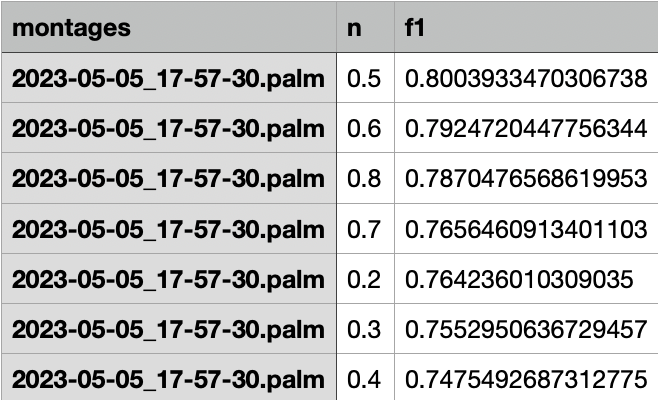

#### fine tuning

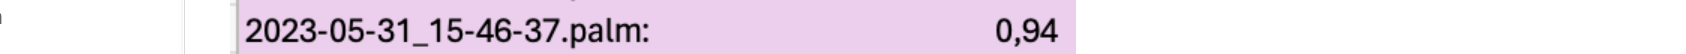

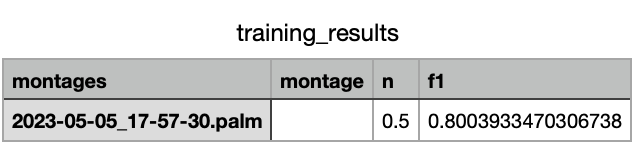

In [ ]:
from tensorflow.keras.models import load_model
from random import sample, choice
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

folder = 'motorica-x-skillfactory-gestures/data'
montages = list(temp['montage'])

results = pd.DataFrame(columns=['n', 'f1'])

montage = '2023-05-22_17-04-29.palm'
filepath = os.path.join(folder, montage)
if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                                n_omg_channels=50,
                                n_acc_channels=3,
                                n_gyr_channels=3,
                                n_enc_channels=6,
                                n_mag_channels=0)

        OMG_CH = [str(i) for i in range(50)]
        X = gestures[OMG_CH]
        y = make_y(gestures, gestures_protocol)

        scaler = StandardScaler()
        X = preprocessing(X, scaler)
        X.columns = X.columns.astype(str)
        X, imp_features_list = imp_features(X, y)
        X = X[imp_features_list]
        X_3d, y_2d = d3_ds(X, y)

        last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
        X_train = X_3d[:last_train_idx]
        y_train = y_2d[:last_train_idx]
        X_test = X_3d[last_train_idx:]
        y_test = y_2d[last_train_idx:]


        n_shift = 10
        n_columns = X.shape[1]
        model_lstm = Sequential()
        model_lstm.add(Bidirectional(LSTM(64), input_shape=(n_columns,n_shift)))
        model_lstm.add(Dense(64, activation='relu'))
        model_lstm.add(Dense(6, activation='softmax'))
        model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history_lstm = model_lstm.fit(X_train, y_train,
                                          epochs=30,
                                          batch_size=32,#
                                          validation_data=(X_test, y_test),
                                          verbose=0)
        model_lstm.save('/content/sample_data/model.h5')

montage = '2023-06-20_14-43-11.palm'
filepath = os.path.join(folder, montage)
if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                                n_omg_channels=50,
                                n_acc_channels=3,
                                n_gyr_channels=3,
                                n_enc_channels=6,
                                n_mag_channels=0)

        OMG_CH = [str(i) for i in range(50)]
        X = gestures[OMG_CH]
        y = make_y(gestures, gestures_protocol)

        scaler = StandardScaler()
        X = preprocessing(X, scaler)
        X.columns = X.columns.astype(str)
        X = X[imp_features_list]
        X_3d, y_2d = d3_ds(X, y)

        for n in range(2,9,1):
          n_ratio = n / 10.0
          X_port_n, X_test_n, y_port_n, y_test_n = train_test_split(X_3d, y_2d, test_size=n_ratio, random_state=42)

          pretrained_model = load_model('/content/sample_data/model.h5')
          for layer in pretrained_model.layers:
              layer.trainable = False  # Optionally freeze layers
          model_lstm = Sequential([
              pretrained_model,
              Dense(64, activation='relu'),
              Dense(len(np.unique(y)), activation='softmax')
          ])

          model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

          history_fine_tuned = model_lstm.fit(X_port_n, y_port_n,
                                              epochs=10,  # Adjust the number of epochs as needed
                                              batch_size=32,
                                              validation_data=(X_test, y_test),
                                              verbose=0)

          # Evaluate the model
          y_pred_test_probs = model_lstm.predict(X_test, verbose=0)
          y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
          f1 = f1_score(np.argmax(y_test, axis=1), y_pred_test_classes, average='weighted')
          print(n, f1)

          results = results.append({'n': 1-n_ratio,
                                      'f1': f1}, ignore_index=True)

results

In [ ]:
from tensorflow.keras.models import load_model
from random import sample, choice
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

folder = 'motorica-x-skillfactory-gestures/data'
montages = list(temp['montage'])

results = pd.DataFrame(columns=['n', 'f1'])

montage = '2023-05-22_17-04-29.palm'
filepath = os.path.join(folder, montage)
if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                                n_omg_channels=50,
                                n_acc_channels=3,
                                n_gyr_channels=3,
                                n_enc_channels=6,
                                n_mag_channels=0)

        OMG_CH = [str(i) for i in range(50)]
        X = gestures[OMG_CH]
        y = make_y(gestures, gestures_protocol)

        scaler = StandardScaler()
        X = preprocessing(X, scaler)
        X.columns = X.columns.astype(str)
        X, imp_features_list = imp_features(X, y)
        X = X[imp_features_list]
        X_3d, y_2d = d3_ds(X, y)

        last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
        X_train = X_3d[:last_train_idx]
        y_train = y_2d[:last_train_idx]
        X_test = X_3d[last_train_idx:]
        y_test = y_2d[last_train_idx:]


        n_shift = 10
        n_columns = X.shape[1]
        model_lstm = Sequential()
        model_lstm.add(Bidirectional(LSTM(64), input_shape=(n_columns,n_shift)))
        model_lstm.add(Dense(64, activation='relu'))
        model_lstm.add(Dense(6, activation='softmax'))
        model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history_lstm = model_lstm.fit(X_train, y_train,
                                          epochs=30,
                                          batch_size=32,
                                          verbose=0)
        model_lstm.save('/content/sample_data/model.h5')

        for n in range(2,9,1):
          n_ratio = n / 10.0
          X_port_n, X_test_n, y_port_n, y_test_n = train_test_split(X_test, y_test, test_size=n_ratio, random_state=42)

          pretrained_model = load_model('/content/sample_data/model.h5')
          for layer in pretrained_model.layers:
              layer.trainable = False  # Optionally freeze layers
          model_lstm = Sequential([
              pretrained_model,
              Dense(64, activation='relu'),
              Dense(len(np.unique(y)), activation='softmax')
          ])

          model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

          history_fine_tuned = model_lstm.fit(X_port_n, y_port_n,
                                              epochs=10,  # Adjust the number of epochs as needed
                                              batch_size=32,
                                              validation_data=(X_test, y_test),
                                              verbose=0)

          # Evaluate the model
          y_pred_test_probs = model_lstm.predict(X_test, verbose=0)
          y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
          f1 = f1_score(np.argmax(y_test, axis=1), y_pred_test_classes, average='weighted')
          print(n, f1)

          results = results.append({'n': 1-n_ratio,
                                      'f1': f1}, ignore_index=True)

results

In [ ]:
results

### test different combinations of ds

In [ ]:
def make_y(gestures, gestures_protocol):
  OMG_CH = [str(i) for i in range(50)]
  le = LabelEncoder()
  # FIT
  le.fit(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )

  # TRANSFORM
  gestures_protocol['gesture'] = le.transform(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )
  y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
  return y_cmd

In [ ]:
def smooth(df):
  alpha = 0.1
  df = pd.DataFrame(df)
  X_smoothed = pd.DataFrame()
  for column in df.columns:
      smoothed_values = [df[column].iloc[0]]  # Initialize with the first observed value
      for i in range(1, len(df)):
          smoothed_value = alpha * df[column].iloc[i] + (1 - alpha) * smoothed_values[-1]
          smoothed_values.append(smoothed_value)
      X_smoothed[column] = smoothed_values
  return X_smoothed

def preprocessing(x, scaler):
    df_smoothed = smooth(x)  # Pass the input variable 'x' instead of 'df_selected'
    array_scaled = scaler.fit_transform(x)  # Use 'x' for scaling
    df_scaled = pd.DataFrame(array_scaled)
    return df_scaled

def imp_features(df, y):
    OMG_CH = [str(i) for i in range(50)]
    df['gest'] = pd.Series(y)
    df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
    std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
    std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
    imp_features_list = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
    df_selected = df[imp_features_list]
    return df_selected,imp_features_list

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  # Import display function
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')
from itertools import combinations

folder = 'motorica-x-skillfactory-gestures/data'
montages = list(temp['montage'])

ds_f1 = {}
for i, montage_test in enumerate(montages):
    X_train = pd.DataFrame()
    y_train = np.array([])
    X_test = pd.DataFrame()
    y_test = np.array([])

    for montage_train in montages[:i] + montages[i+1:]:
        filepath_train = os.path.join(folder, montage_train)
        if os.path.exists(filepath_train):
            protocol_path_train = filepath_train + '.protocol.csv'
            gestures_protocol_train = pd.read_csv(protocol_path_train, index_col=0)
            palm_file_train = filepath_train
            gestures_train = read_omg_csv(palm_file_train,
                                          n_omg_channels=50,
                                          n_acc_channels=3,
                                          n_gyr_channels=3,
                                          n_enc_channels=6,
                                          n_mag_channels=0)
            OMG_CH_train = [str(i) for i in range(50)]
            y_cmd_train = make_y(gestures_train, gestures_protocol_train)
            df_train = gestures_train[OMG_CH_train]
            df_preprocessed_train = preprocessing(df_train)
            X_train = pd.concat([X_train, df_preprocessed_train])
            y_train = np.concatenate([y_train, y_cmd_train])

    filepath_test = os.path.join(folder, montage_test)
    if os.path.exists(filepath_test):
        protocol_path_test = filepath_test + '.protocol.csv'
        gestures_protocol_test = pd.read_csv(protocol_path_test, index_col=0)
        palm_file_test = filepath_test
        gestures_test = read_omg_csv(palm_file_test,
                                      n_omg_channels=50,
                                      n_acc_channels=3,
                                      n_gyr_channels=3,
                                      n_enc_channels=6,
                                      n_mag_channels=0)
        OMG_CH_test = [str(i) for i in range(50)]
        y_cmd_test = make_y(gestures_test, gestures_protocol_test)
        X_test = pd.concat([X_test, gestures_test[OMG_CH_test]])
        y_test = np.concatenate([y_test, y_cmd_test])
    X_train.columns = X_train.columns.astype(str)
    X_val, imp_features_list = imp_features(X_train, y_train)
    X_test = X_test[imp_features_list]
    model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=30)
    model_boost.fit(X_val, y_train, eval_set=(X_test, y_test))
    y_pred = model_boost.predict(X_test)
    f1 = f1_score(y_test, y_pred,average='weighted')
    print(montage_test,X_test.shape, f1)
    ds_f1[i] = f1

report = pd.DataFrame(ds_f1, columns=['test_ds', 'f1'])
ds_f1

In [ ]:
folder = 'motorica-x-skillfactory-gestures/data'
montages = list(temp['montage'])

montage_list = []
f1_list=[]

for i, montage_train in enumerate(montages):

    filepath_train = os.path.join(folder, montage_train)
    if os.path.exists(filepath_train):
        protocol_path_train = filepath_train + '.protocol.csv'
        gestures_protocol_train = pd.read_csv(protocol_path_train, index_col=0)
        palm_file_train = filepath_train
        gestures_train = read_omg_csv(palm_file_train,
                                      n_omg_channels=50,
                                      n_acc_channels=3,
                                      n_gyr_channels=3,
                                      n_enc_channels=6,
                                      n_mag_channels=0)
        OMG_CH = [str(i) for i in range(50)]
        X_train = gestures_train[OMG_CH]
        y_train = make_y(gestures_train, gestures_protocol_train)
        scaler = StandardScaler()
        X_train = preprocessing(X_train,scaler)
        X_train.columns = X_train.columns.astype(str)
        X_val, imp_features_list = imp_features(X_train, y_train)

    for montage_test in montages[:i] + montages[i+1:]:
        filepath_test = os.path.join(folder, montage_test)
        if os.path.exists(filepath_test):
            protocol_path_test = filepath_test + '.protocol.csv'
            gestures_protocol_test = pd.read_csv(protocol_path_test, index_col=0)
            palm_file_test = filepath_test
            gestures_test = read_omg_csv(palm_file_test,
                                          n_omg_channels=50,
                                          n_acc_channels=3,
                                          n_gyr_channels=3,
                                          n_enc_channels=6,
                                          n_mag_channels=0)
            OMG_CH = [str(i) for i in range(50)]
            y_test = make_y(gestures_test, gestures_protocol_test)
            X_test = gestures_test[OMG_CH]
            X_test = preprocessing(X_test, scaler)
            X_test.columns = X_test.columns.astype(str)
            X_test = X_test[imp_features_list]
            model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=30)
            model_boost.fit(X_val, y_train, eval_set=(X_test, y_test))
            y_pred = model_boost.predict(X_test)
            f1 = f1_score(y_test, y_pred,average='weighted')
            montage_list.append(montage_train)
            f1_list.append(f1)



In [ ]:
report = pd.DataFrame(columns = ['train_ds', 'f1'])
report['train_ds'] = montage_list
report['f1']=f1_list
report.sort_values(by='f1', ascending=False)

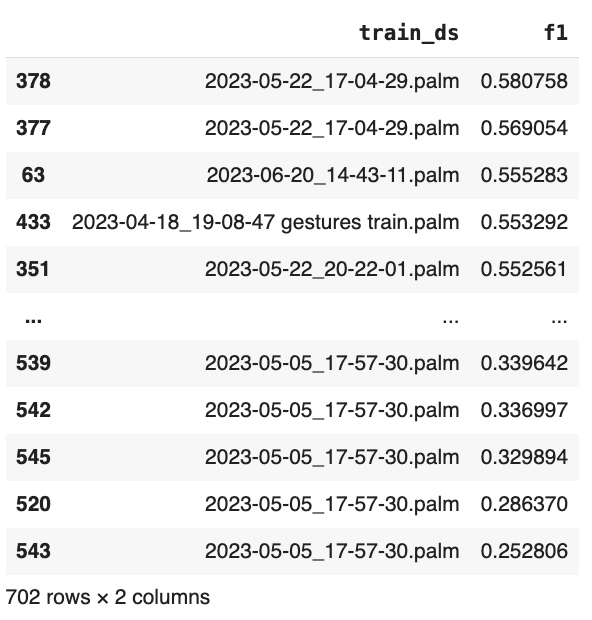

In [ ]:
#pilot1
import os
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  # Import display function

warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
X_train = pd.DataFrame()
y_train = np.array([])
X_test = pd.DataFrame()
y_test = np.array([])

for i, montage in enumerate(pilot1):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
        OMG_CH = [str(i) for i in range(50)]
        y_cmd = make_y(gestures, gestures_protocol)
        if montage == '2023-06-05_17-53-01.palm':
            X_test = pd.concat([X_test, gestures[OMG_CH]])
            y_test = np.concatenate([y_test, y_cmd])
        else:
          df = gestures[OMG_CH]
          df_preprocessed = preprocessing(df)
          X_train = pd.concat([X_train, df_preprocessed])
          y_train = np.concatenate([y_train, y_cmd])

display(X_train.head())
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.columns = X_train.columns.astype(str)
X_val, imp_features = imp_features(X_train, y_train)
print(imp_features)
X_test = X_test[imp_features]


fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(X_val.values)
plt.title('train')

plt.sca(axx[1])
plt.plot(y_train)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('Val')
plt.tight_layout()

In [ ]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier with the specified parameters
model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=30)

# Fit the model to the training data
model_boost.fit(X_val, y_train, eval_set=(X_test, y_test))

# Predict on the test set and evaluate performance
y_pred = model_boost.predict(X_test)
print(classification_report(y_test, y_pred, target_names=GESTURES))

cm = confusion_matrix(y_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

In [ ]:
#pilot3
import os
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  # Import display function

warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
X_train = pd.DataFrame()
y_train = np.array([])
X_test = pd.DataFrame()
y_test = np.array([])

for i, montage in enumerate(pilot3):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
        OMG_CH = [str(i) for i in range(50)]
        y_cmd = make_y(gestures, gestures_protocol)
        if montage == '2023-05-07_16-54-27.palm':
            X_test = pd.concat([X_test, gestures[OMG_CH]])
            y_test = np.concatenate([y_test, y_cmd])
        else:
          df = gestures[OMG_CH]
          df_preprocessed = preprocessing(df)
          X_train = pd.concat([X_train, df_preprocessed])
          y_train = np.concatenate([y_train, y_cmd])

display(X_train.head())
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.columns = X_train.columns.astype(str)
X_val, imp_features = imp_features(X_train, y_train)
print(imp_features)
X_test = X_test[imp_features]


fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(X_val.values)
plt.title('train')

plt.sca(axx[1])
plt.plot(y_train)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('Val')
plt.tight_layout()


In [ ]:
# Initialize CatBoostClassifier with the specified parameters
model_boost = CatBoostClassifier(depth=7, eval_metric='Accuracy', verbose=False, iterations=30)

# Fit the model to the training data
model_boost.fit(X_val, y_train, eval_set=(X_test, y_test))

# Predict on the test set and evaluate performance
y_pred = model_boost.predict(X_test)
print(classification_report(y_test, y_pred, target_names=GESTURES))

cm = confusion_matrix(y_test, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
class_names = [str(int(cls)) for cls in np.unique(y_test)]
cm_percent_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set (Percentages)')
plt.show()

## Test pilots

In [ ]:
bad = ['2023-05-15_17-12-24.palm', '2023-06-05_16-12-38.palm', '2023-10-18_08-05-29.palm', '2023-10-25_11-08-46.palm']
temp = df_meta[~df_meta['montage'].isin(bad)]


pilot1 = list(temp[temp['pilote_id'] == 1]['montage']) #2023-06-05_17-53-01.palm-test
pilot2 = list(temp[temp['pilote_id'] == 2]['montage']) #2023-09-12_14-59-23.palm,2023-09-12_12-55-22.palm,2023-09-13_22-14-05.palm - test
pilot3 = list(temp[temp['pilote_id'] == 3]['montage']) #2023-05-07_16-54-27.palm - test

In [ ]:
def make_y(gestures, gestures_protocol):
  OMG_CH = [str(i) for i in range(50)]
  le = LabelEncoder()
  # FIT
  le.fit(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )

  # TRANSFORM
  gestures_protocol['gesture'] = le.transform(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )
  y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
  return y_cmd


In [ ]:
def preprocessing(df, y_train):
  df.reset_index(inplace=True)
  # select important features
  df['gest'] = pd.Series(y_train)
  df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
  std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
  std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
  imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
  df_selected = df[imp_features]
  # add previous timesteps values
  new_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
  cols = new_df.columns[:df_shifted.shape[1]]
  for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
  new_df.fillna(new_df.median(), inplace=True)
  # median of previous ts
  median_ts_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
  cols = median_ts_df.columns[:df_shifted.shape[1]]
  for i in cols:
      median_ts_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
  median_ts_df.fillna(median_ts_df.median(), inplace=True)
  for n in range(len(median_ts_df)):
      for i in cols:
          median_ts_df.loc[n, f'col_{i}_median'] = median_ts_df.loc[n, [f'col_{j}_{i}' for j in range(1, 10)]].median()
  cols_0 = [f'col_0_{i}' for i in cols]
  cols_med = [f'col_{i}_median' for i in cols]
  median_ts_df = median_ts_df[cols_0 + cols_med]

  return new_df,median_ts_df,imp_features,max_correlation_shift

In [ ]:
def lstm(X_train_new,X_train_shifted,X_test_new,X_test_shifted,y_train,y_test,imp_features):
    #3d
    n_columns = len(imp_features)
    n_shift = 10
    X_train_3d = X_train_new.to_numpy().reshape(X_train_new.shape[0], n_columns, n_shift)[:,::-1,:]
    X_test_3d = X_test_new.to_numpy().reshape(X_test_new.shape[0], n_columns, n_shift)[:,::-1,:]

    ##scale
    scaler = StandardScaler()
    X_train_3d=scaler.fit_transform(X_train_3d.reshape(-1, X_train_3d.shape[-1])).reshape(X_train_3d.shape)
    X_test_3d=scaler.transform(X_test_3d.reshape(-1, X_test_3d.shape[-1])).reshape(X_test_3d.shape)

    y_train_2d = to_categorical(y_train)
    y_test_2d = to_categorical(y_test)

    #2d
    ##scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_shifted)
    X_test_scaled = scaler.transform(X_test_shifted)

    #model
    ## lstm
    input_lstm = Input(shape=(n_columns, n_shift))
    lstm_output = Bidirectional(LSTM(64))(input_lstm)
    dense_layer_lstm = Dense(64, activation='relu')(lstm_output)
    ## ffn
    input_ffn = Input(shape=(n_columns, ))
    flatten_layer_ffn = Flatten()(input_ffn)
    dense_layer_ffn1 = Dense(32, activation='relu')(flatten_layer_ffn)
    dense_layer_ffn2 = Dense(64, activation='relu')(dense_layer_ffn1)
    dense_layer_ffn3 = Dense(128, activation='relu')(dense_layer_ffn2)
    # Concatenate
    merged = concatenate([dense_layer_lstm, dense_layer_ffn3])
    dense_layer_merged = Dense(128, activation='relu')(merged)
    output = Dense(len(np.unique(y_cmd)), activation='softmax')(dense_layer_merged)
    combined_model = Model(inputs=[input_lstm, input_ffn], outputs=output)
    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    combined_model.fit([X_train_3d, X_train_scaled],
                      y_train_2d, epochs=40, batch_size=32,
                      validation_data=([X_test_3d, X_test_scaled], y_test_2d),
                      verbose=0)
    # f1 score
    y_pred_train_probs = combined_model.predict([X_train_3d, X_train_scaled], verbose=0)
    y_pred_train_classes = np.argmax(y_pred_train_probs, axis=1)
    f1_train = f1_score(np.argmax(y_train_2d, axis=1), y_pred_train_classes, average='weighted')

    y_pred_test_probs = combined_model.predict([X_test_3d, X_test_scaled], verbose=0)
    y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
    f1_test = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')
    K.clear_session()

    return f1_train, f1_test

### pilot1

In [ ]:
#pilot1
import os
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  # Import display function

warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
X_train = pd.DataFrame()
y_train = np.array([])
X_test = pd.DataFrame()
y_test = np.array([])

for i, montage in enumerate(pilot1):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
        OMG_CH = [str(i) for i in range(50)]
        y_cmd = make_y(gestures, gestures_protocol)
        if montage == '2023-06-05_17-53-01.palm':
            X_test = pd.concat([X_test, gestures[OMG_CH]])
            y_test = np.concatenate([y_test, y_cmd])
        else:
            X_train = pd.concat([X_train, gestures[OMG_CH]])
            y_train = np.concatenate([y_train, y_cmd])

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
display(X_train.head())

In [ ]:
df=X_train.copy()
df.reset_index(inplace=True)
df['gest'] = pd.Series(y_train)
df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
df_selected = df[imp_features]
display(df_selected.columns)

# remove time delay
cor_list = {}
for shift_value in range(0, -20, -1):
      temp = df_selected.copy()
      cols = df_selected.columns
      scaler = StandardScaler()
      temp_scaled = scaler.fit_transform(temp)  # Changed X to temp
      temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)  # Changed X to temp
      scaled_temp = temp_scaled_df.apply(lambda x: np.abs(x))  # Changed scaled_temp to temp_scaled_df
      scaled_temp['disp'] = scaled_temp[cols].sum(axis=1)
      shifted_temp = scaled_temp.shift(shift_value)
      shifted_temp.fillna(shifted_temp.median(), inplace=True)  # Added inplace=True to fillna
      correlation = shifted_temp['disp'].corr(pd.Series(y_train))
      cor_list[shift_value] = correlation
max_correlation_shift = max(cor_list, key=cor_list.get)
df_shifted = df_selected.shift(max_correlation_shift)
df_shifted.fillna(0,inplace=True)
display(df_shifted.shape)

# add previous timesteps values
new_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = new_df.columns[:df_shifted.shape[1]]
for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
new_df.fillna(new_df.median(), inplace=True)
display(new_df.shape)

# median of previous ts
median_ts_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = median_ts_df.columns[:df_shifted.shape[1]]
for i in cols:
      median_ts_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
median_ts_df.fillna(median_ts_df.median(), inplace=True)
for n in range(len(median_ts_df)):
      for i in cols:
          median_ts_df.loc[n, f'col_{i}_median'] = median_ts_df.loc[n, [f'col_{j}_{i}' for j in range(1, 10)]].median()
cols_0 = [f'col_0_{i}' for i in cols]
cols_med = [f'col_{i}_median' for i in cols]
median_ts_df = median_ts_df[cols_0 + cols_med]
display(median_ts_df.shape)

#X_train_new,X_train_median,imp_features,max_correlation_shift = preprocessing(X_train, y_train)
X_train_new = new_df.copy()
X_train_median = median_ts_df.copy()
X_test_selected=X_test[imp_features]
X_test_shifted = X_test_selected.shift(max_correlation_shift)
X_test_shifted.fillna(0, inplace=True)
X_test_new = pd.concat([X_test_shifted] + [X_test_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = X_test_new.columns[:X_test_shifted.shape[1]]
for i in cols:
  X_test_new.rename(columns={i: f'col_0_{i}'}, inplace=True)
X_test_new.fillna(X_test_new.median(), inplace=True)

X_test_median = pd.concat([X_test_shifted] + [X_test_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = X_test_median.columns[:X_test_shifted.shape[1]]
for i in cols:
      X_test_median.rename(columns={i: f'col_0_{i}'}, inplace=True)
X_test_median.fillna(X_test_median.median(), inplace=True)
for n in range(len(X_test_median)):
      for i in cols:
          X_test_median.loc[n, f'col_{i}_median'] = X_test_median.loc[n, [f'col_{j}_{i}' for j in range(1, 10)]].median()
cols_0 = [f'col_0_{i}' for i in cols]
cols_med = [f'col_{i}_median' for i in cols]
X_test_median = X_test_median[cols_0 + cols_med]

display(X_train_new.shape,X_train_median.shape,
        X_test_new.shape,X_test_median.shape)

f1_train, f1_test = lstm(X_train_new,X_train_median,X_test_new,X_test_median,y_train,y_test,imp_features)
print('train',f1_train,
      'test', f1_test)

pilot1

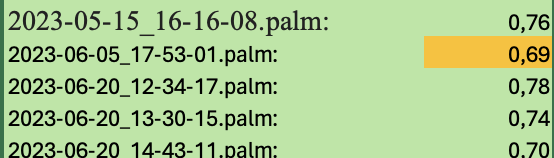


train=0.98

test 2023-06-05_17-53-01.palm=0.46

### pilot2

In [ ]:
#pilot2
folder = 'motorica-x-skillfactory-gestures/data'
X_train = pd.DataFrame()
y_train = np.array([])
X_test = pd.DataFrame()
y_test = np.array([])

pilot2_selected = ['2023-05-22_17-04-29.palm', '2023-05-31_15-46-37.palm','2023-10-23_10-11-45.palm','2023-10-25_08-52-30.palm']
test_list = ['2023-09-12_14-59-23.palm','2023-09-12_12-55-22.palm','2023-09-13_22-14-05.palm']


for i, montage in enumerate(pilot2):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
        OMG_CH = [str(i) for i in range(50)]
        y_cmd = make_y(gestures, gestures_protocol)

        if montage in test_list:
            X_test = pd.concat([X_test, gestures[OMG_CH]])
            y_test = np.concatenate([y_test, y_cmd])
        elif montage in pilot2_selected:
            X_train = pd.concat([X_train, gestures[OMG_CH]])
            y_train = np.concatenate([y_train, y_cmd])

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
display(X_train.head(),
        X_test.head())


df=X_train.copy()
df.reset_index(inplace=True)
df['gest'] = pd.Series(y_train)
df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
df_selected = df[imp_features]
display(imp_features)

# remove time delay
cor_list = {}
for shift_value in range(0, -20, -1):
      temp = df_selected.copy()
      cols = df_selected.columns
      scaler = StandardScaler()
      temp_scaled = scaler.fit_transform(temp)  # Changed X to temp
      temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)  # Changed X to temp
      scaled_temp = temp_scaled_df.apply(lambda x: np.abs(x))  # Changed scaled_temp to temp_scaled_df
      scaled_temp['disp'] = scaled_temp[cols].sum(axis=1)
      shifted_temp = scaled_temp.shift(shift_value)
      shifted_temp.fillna(shifted_temp.median(), inplace=True)  # Added inplace=True to fillna
      correlation = shifted_temp['disp'].corr(pd.Series(y_train))
      cor_list[shift_value] = correlation
max_correlation_shift = max(cor_list, key=cor_list.get)
df_shifted = df_selected.shift(max_correlation_shift)
df_shifted.fillna(0,inplace=True)
display(df_shifted.shape)
X_train_shifted = df_shifted.copy()

# add previous timesteps values
new_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = new_df.columns[:df_shifted.shape[1]]
for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
new_df.fillna(new_df.median(), inplace=True)
X_train_new = new_df.copy()
display(X_train_new.shape)

#X_train_new,X_train_median,imp_features,max_correlation_shift = preprocessing(X_train,y_train)

X_test_selected=X_test[imp_features]
X_test_shifted = X_test_selected.shift(max_correlation_shift)
X_test_shifted.fillna(0, inplace=True)
X_test_new = pd.concat([X_test_shifted] + [X_test_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = X_test_new.columns[:X_test_shifted.shape[1]]
for i in cols:
  X_test_new.rename(columns={i: f'col_0_{i}'}, inplace=True)
X_test_new.fillna(X_test_new.median(), inplace=True)


display(X_train_new.shape,X_train_shifted.shape,
        X_test_new.shape,X_test_shifted.shape)

f1_train, f1_test = lstm(X_train_new,X_train_shifted,X_test_new,X_test_shifted,y_train,y_test,imp_features)
print('train',f1_train,
      'test', f1_test)

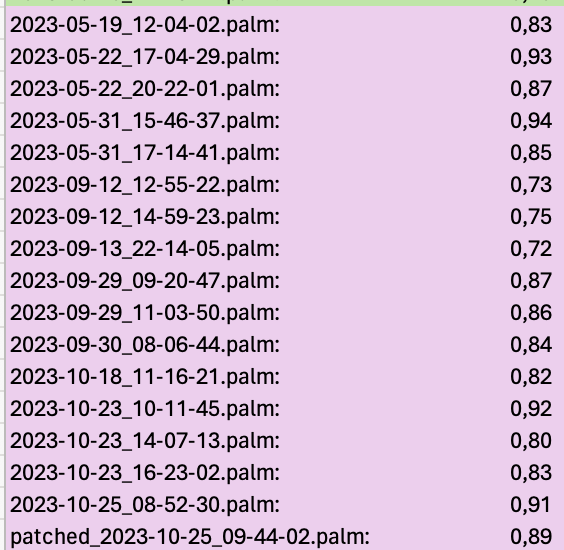

pilot2_selected = ['2023-05-22_17-04-29.palm', '2023-05-31_15-46-37.palm','2023-10-23_10-11-45.palm','2023-10-25_08-52-30.palm']

f1_train = 0.778

test_list = ['2023-09-12_14-59-23.palm','2023-09-12_12-55-22.palm','2023-09-13_22-14-05.palm']

f1_test = 0.404

### pilot3

In [ ]:
# pilot3

folder = 'motorica-x-skillfactory-gestures/data'
X_train = pd.DataFrame()
y_train = np.array([])
X_test = pd.DataFrame()
y_test = np.array([])

for i, montage in enumerate(pilot3):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
        OMG_CH = [str(i) for i in range(50)]
        y_cmd = make_y(gestures, gestures_protocol)
        if montage == '2023-05-07_16-54-27.palm':
            X_test = pd.concat([X_test, gestures[OMG_CH]])
            y_test = np.concatenate([y_test, y_cmd])
        else:
            X_train = pd.concat([X_train, gestures[OMG_CH]])
            y_train = np.concatenate([y_train, y_cmd])

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
display(X_train.head())

df=X_train.copy()
df.reset_index(inplace=True)
df['gest'] = pd.Series(y_train)
df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
std_dev_per_label = df.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
df_selected = df[imp_features]
display(imp_features)

# remove time delay
cor_list = {}
for shift_value in range(0, -20, -1):
      temp = df_selected.copy()
      cols = df_selected.columns
      scaler = StandardScaler()
      temp_scaled = scaler.fit_transform(temp)  # Changed X to temp
      temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)  # Changed X to temp
      scaled_temp = temp_scaled_df.apply(lambda x: np.abs(x))  # Changed scaled_temp to temp_scaled_df
      scaled_temp['disp'] = scaled_temp[cols].sum(axis=1)
      shifted_temp = scaled_temp.shift(shift_value)
      shifted_temp.fillna(shifted_temp.median(), inplace=True)  # Added inplace=True to fillna
      correlation = shifted_temp['disp'].corr(pd.Series(y_train))
      cor_list[shift_value] = correlation
max_correlation_shift = max(cor_list, key=cor_list.get)
df_shifted = df_selected.shift(max_correlation_shift)
df_shifted.fillna(0,inplace=True)
display(df_shifted.shape)
X_train_shifted=df_shifted.copy()

# add previous timesteps values
new_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = new_df.columns[:df_shifted.shape[1]]
for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
new_df.fillna(new_df.median(), inplace=True)
X_train_new = new_df.copy()
display(new_df.shape)

#X_train_new,X_train_median,imp_features,max_correlation_shift = preprocessing(X_train,y_train)

X_test_selected=X_test[imp_features]
X_test_shifted = X_test_selected.shift(max_correlation_shift)
X_test_shifted.fillna(0, inplace=True)
X_test_new = pd.concat([X_test_shifted] + [X_test_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
cols = X_test_new.columns[:X_test_shifted.shape[1]]
for i in cols:
  X_test_new.rename(columns={i: f'col_0_{i}'}, inplace=True)
X_test_new.fillna(X_test_new.median(), inplace=True)


display(X_train_new.shape,X_train_shifted.shape,
        X_test_new.shape,X_test_shifted.shape)

f1_train, f1_test = lstm(X_train_new,X_train_shifted,X_test_new,X_test_shifted,y_train,y_test,imp_features)
print('train',f1_train,
      'test', f1_test)

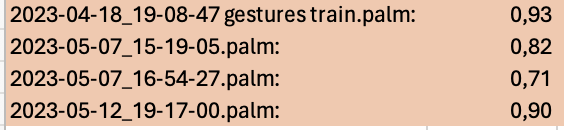

train=0.981

test 2023-05-07_16-54-27.palm = 0.54

## 0 vs 3 for pilots

In [ ]:
def preprocessing(gestures, gestures_protocol):
  OMG_CH = [str(i) for i in range(50)]
  le = LabelEncoder()
  # FIT
  le.fit(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )

  # TRANSFORM
  gestures_protocol['gesture'] = le.transform(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )
  y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

  # select important features
  df = gestures[OMG_CH]
  cols=df.columns
  df['gest'] = pd.Series(y_cmd)
  df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
  std_dev_per_label = df.groupby('label', as_index=False)[cols].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
  std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
  imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
  df_selected = df[imp_features]
  #scale
  scaler = StandardScaler()
  df_selected_scaled = scaler.fit_transform(df_selected)
  #smooth
  df_smoothed = smooth(df_selected_scaled)
  # remove time delay
  df_shifted = shift(df_smoothed, y_cmd)
  #select gestures
  indx = (y_cmd == 0) | (y_cmd == 3)
  df_indx = df_selected[indx]
  y_indx = y_cmd[indx]

  return df_indx,y_indx

In [ ]:
def gest_compare(df_indx,y_indx):
  X_train, X_test, y_train, y_test = train_test_split(df_indx, y_indx, test_size=0.2, random_state=42, stratify=y_indx)
  model = DecisionTreeClassifier(
      max_depth=48,
      min_samples_split=7,
      min_samples_leaf=1,
      max_features=0.71,
      random_state=42
  )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  f1 = f1_score(y_test, y_pred,average='binary',pos_label=3)
  return f1

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
bad = ['2023-05-15_17-12-24.palm', '2023-06-05_16-12-38.palm', '2023-10-18_08-05-29.palm', '2023-10-25_11-08-46.palm']
temp = df_meta[~df_meta['montage'].isin(bad)]
montage_list = []
score_list=[]
pilot_list=[]
df_score_03 = pd.DataFrame(columns=['montage','f1_score','pilot'])

for i, montage in enumerate(temp['montage']):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
    df_indx,y_indx = preprocessing(gestures, gestures_protocol)
    f1 = gest_compare(df_indx,y_indx)
    montage_list.append(montage)
    score_list.append(f1)
    pilot = df_meta.loc[i,'pilote_id']
    pilot_list.append(pilot)
    print(f'{montage}: {f1}')
df_score_03['montage'] = montage_list
df_score_03['f1_score'] = score_list
df_score_03['pilot'] = pilot_list

display(df_score_03.sort_values(by='pilot', ascending=False))

In [ ]:
df_score_03.to_csv('/content/sample_data/df_score_03.csv')

## Combo net

In [ ]:
def smooth(df):
  alpha = 0.1
  df = pd.DataFrame(df)
  X_smoothed = pd.DataFrame()
  for column in df.columns:
      smoothed_values = [df[column].iloc[0]]  # Initialize with the first observed value
      for i in range(1, len(df)):
          smoothed_value = alpha * df[column].iloc[i] + (1 - alpha) * smoothed_values[-1]
          smoothed_values.append(smoothed_value)
      X_smoothed[column] = smoothed_values
  return X_smoothed

In [ ]:
def shift(df, y_cmd):
    cor_list = {}
    temp = df.apply(lambda x: np.abs(x))
    cols = df.columns
    temp['disp'] = temp[cols].sum(axis=1)
    for shift_value in range(0, -30, -1):
        shifted_temp = temp.shift(shift_value)
        shifted_temp.fillna(shifted_temp.median(), inplace=True)
        correlation = shifted_temp['disp'].corr(pd.Series(y_cmd))
        cor_list[shift_value] = correlation
    max_correlation_shift = max(cor_list, key=cor_list.get)
    df_shifted = df.shift(max_correlation_shift)
    df_shifted.fillna(0, inplace=True)
    return df_shifted

In [ ]:
df = gestures[OMG_CH].drop('13', axis=1)
df.columns

In [ ]:
def preprocessing(gestures, gestures_protocol):
  OMG_CH = [str(i) for i in range(50)]
  le = LabelEncoder()
  # FIT
  le.fit(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )

  # TRANSFORM
  gestures_protocol['gesture'] = le.transform(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )
  y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

  # select important features
  df = gestures[OMG_CH].drop('13', axis=1)
  cols=df.columns
  df['gest'] = pd.Series(y_cmd)
  df['label'] = df['gest'].apply(lambda x: '0' if x == 0 else '1')
  std_dev_per_label = df.groupby('label', as_index=False)[cols].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
  std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
  imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
  df_selected = df[imp_features]
  #scale
  scaler = StandardScaler()
  df_selected_scaled = scaler.fit_transform(df_selected)
  #smooth
  df_smoothed = smooth(df_selected_scaled)
  # remove time delay
  df_shifted = shift(df_smoothed, y_cmd)
  # add previous timesteps values
  new_df = pd.concat([df_shifted] + [df_shifted.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
  cols = new_df.columns[:df_shifted.shape[1]]
  for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
  new_df.fillna(new_df.median(), inplace=True)
  print(df_shifted.shape,new_df.shape, len(imp_features))
  return df_shifted,new_df,y_cmd,imp_features

In [ ]:
def lstm(df_shifted,new_df,y_cmd,imp_features):
    last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
    #3d
    n_columns = len(imp_features)
    n_shift = 10
    reshaped_array = new_df.to_numpy().reshape(new_df.shape[0], n_columns, n_shift)[:,::-1,:]
    X_train_3d = reshaped_array[:last_train_idx]
    y_train_2d= y_cmd[:last_train_idx]
    X_test_3d  = reshaped_array[last_train_idx:]
    y_test_2d = y_cmd[last_train_idx:]
    ##categorical y
    y_train_2d = to_categorical(y_train_2d)
    y_test_2d = to_categorical(y_test_2d)

    #2d
    X_train = df_shifted.values[:last_train_idx]
    y_train = y_cmd[:last_train_idx]
    X_test = df_shifted.values[last_train_idx:]
    y_test = y_cmd[last_train_idx:]

    #model
    ## lstm
    input_lstm = Input(shape=(n_columns, n_shift))
    lstm_output = Bidirectional(LSTM(64))(input_lstm)
    dense_layer_lstm = Dense(64, activation='relu')(lstm_output)
    ## ffn
    input_ffn = Input(shape=(n_columns, ))
    flatten_layer_ffn = Flatten()(input_ffn)
    dense_layer_ffn1 = Dense(32, activation='relu')(flatten_layer_ffn)
    dense_layer_ffn2 = Dense(64, activation='relu')(dense_layer_ffn1)
    dense_layer_ffn3 = Dense(128, activation='relu')(dense_layer_ffn2)
    # Concatenate
    merged = concatenate([dense_layer_lstm, dense_layer_ffn3])
    dense_layer_merged = Dense(128, activation='relu')(merged)
    output = Dense(len(np.unique(y_cmd)), activation='softmax')(dense_layer_merged)
    combined_model = Model(inputs=[input_lstm, input_ffn], outputs=output)
    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    combined_model.fit([X_train_3d, X_train],
                      y_train_2d, epochs=40, batch_size=32,
                      validation_data=([X_test_3d, X_test], y_test_2d),
                      verbose=0)
    # f1 score
    y_pred_test_probs = combined_model.predict([X_test_3d, X_test], verbose=0)
    y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
    f1 = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')
    K.clear_session()

    return f1

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
bad = ['2023-05-15_17-12-24.palm', '2023-06-05_16-12-38.palm', '2023-10-18_08-05-29.palm', '2023-10-25_11-08-46.palm']
temp = df_meta[~df_meta['montage'].isin(bad)]
montage_list = []
score_list=[]
pilot_list=[]
df_score_lstm = pd.DataFrame(columns=['montage','f1_score','pilot'])

for i, montage in enumerate(temp['montage']):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
    df_shifted,new_df,y_cmd,imp_features = preprocessing(gestures, gestures_protocol)
    f1 = lstm(df_shifted,new_df,y_cmd,imp_features)
    montage_list.append(montage)
    score_list.append(f1)
    pilot = df_meta.loc[i,'pilote_id']
    pilot_list.append(pilot)
    print(f'{montage}: {f1}')
df_score_lstm['montage'] = montage_list
df_score_lstm['f1_score'] = score_list
df_score_lstm['pilot'] = pilot_list

df_score_lstm.to_csv('/content/sample_data/df_score_combined.csv')

display(df_score_lstm.sort_values(by='pilot', ascending=False))

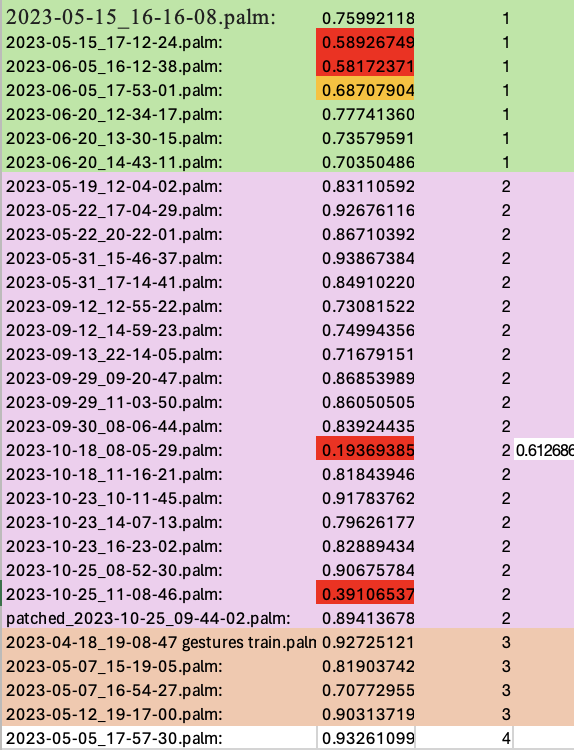

In [ ]:
df_score_lstm.to_csv('/content/sample_data/df_score_combined.csv')

In [ ]:
df_score_lstm.sort_values(by='pilot', ascending=False)

In [ ]:
#bad_q = list(df_score_lstm[df_score_lstm['f1_score']<0.75]['montage'])
bad_q=['2023-05-15_17-12-24.palm',
 '2023-06-05_16-12-38.palm',
 '2023-06-05_17-53-01.palm',
 '2023-06-20_14-43-11.palm',
 '2023-06-20_13-30-15.palm',
 '2023-06-20_12-34-17.palm',
 '2023-09-13_22-14-05.palm',
 '2023-09-12_14-59-23.palm',
 '2023-09-12_12-55-22.palm',
 '2023-10-25_11-08-46.palm',
 '2023-10-18_08-05-29.palm',
 '2023-10-18_11-16-21.palm']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_score_lstm = pd.read_csv('/content/drive/MyDrive/motorika/df_score_lstm.csv', sep=';')
df_score_lstm

In [ ]:
df_score_lstm.groupby('pilote_id').agg({
    'f1_score': ['mean', 'std', 'min', 'max'],
    'shift': ['mean', 'std', 'min', 'max']
}).reset_index()

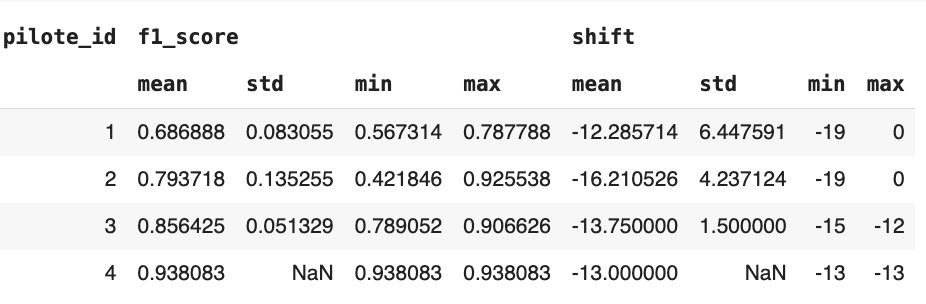

In [ ]:
def preprocessing_svm(gestures, gestures_protocol):
  OMG_CH = [str(i) for i in range(50)]
  le = LabelEncoder()
  # FIT
  le.fit(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )

  # TRANSFORM
  gestures_protocol['gesture'] = le.transform(
      gestures_protocol[[
          "Thumb","Index","Middle","Ring","Pinky",
          'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
      ]]
      .apply(lambda row: str(tuple(row)), axis=1)
  )
  y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
  df = gestures[OMG_CH]
  # smooth
  alpha = 0.006
  df_smoothed = pd.DataFrame()
  for column in df.columns:
    smoothed_values = [df[column].iloc[0]]  # Initialize with the first observed value
    for i in range(1, len(df)):
        smoothed_value = alpha * df[column].iloc[i] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)
    df_smoothed[column] = smoothed_values
  # select important features
  df_smoothed['gest'] = pd.Series(y_cmd)
  df_smoothed['label'] = df_smoothed['gest'].apply(lambda x: '0' if x == 0 else '1')
  std_dev_per_label = df_smoothed.groupby('label', as_index=False)[OMG_CH].std().T.reset_index().rename(columns={'index':'column'}).drop(0, axis=0)
  std_dev_per_label['std_dif'] = (std_dev_per_label[1]-std_dev_per_label[0]).abs()
  imp_features = list(std_dev_per_label.sort_values(by='std_dif', ascending=False)['column'][:12])
  df_selected = df_smoothed[imp_features]
  # remove time delay
  cor_list = {}
  for shift_value in range(0, -20, -1):
      temp = df_selected.copy()
      cols = df_selected.columns
      scaler = StandardScaler()
      temp_scaled = scaler.fit_transform(temp)  # Changed X to temp
      temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)  # Changed X to temp
      scaled_temp = temp_scaled_df.apply(lambda x: np.abs(x))  # Changed scaled_temp to temp_scaled_df
      scaled_temp['disp'] = scaled_temp[cols].sum(axis=1)
      shifted_temp = scaled_temp.shift(shift_value)
      shifted_temp.fillna(shifted_temp.median(), inplace=True)  # Added inplace=True to fillna
      correlation = shifted_temp['disp'].corr(pd.Series(y_cmd))
      cor_list[shift_value] = correlation
  max_correlation_shift = max(cor_list, key=cor_list.get)
  df_shifted = df_selected.shift(max_correlation_shift)
  df_shifted_clean = df_shifted.fillna(0)
  # add previous timesteps values
  new_df = pd.concat([df_shifted_clean] + [df_shifted_clean.shift(i).add_prefix(f'col_{i}_') for i in range(1, 10)], axis=1)
  cols = imp_features
  for i in cols:
    new_df.rename(columns={i: f'col_0_{i}'}, inplace=True)
  new_df.fillna(new_df.median(), inplace=True)
  # median of previous ts
  for n in range(len(new_df)):
        for i in cols:
            new_df.loc[n, f'col_{i}_median'] = new_df.loc[n, [f'col_{j}_{i}' for j in range(1, 10)]].median()
  cols_0 = [f'col_0_{i}' for i in cols]
  cols_med = [f'col_{i}_median' for i in cols]
  new_df = new_df[cols_0 + cols_med]
  return new_df,y_cmd,imp_features,max_correlation_shift

In [ ]:
def svm(new_df,y_cmd,imp_features):
    last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
    #split
    X_train = new_df.values[:last_train_idx]
    y_train = y_cmd[:last_train_idx,]
    X_test = new_df.values[last_train_idx:]
    y_test = y_cmd[last_train_idx:]
    #scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #smote
    class_counts = pd.Series(y_cmd).value_counts()
    min_class_count = class_counts.min()
    n_neighbors = min(min_class_count-1, 6)
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
    #model
    svm_model = SVC(C=0.5, gamma='scale',kernel='linear',class_weight='balanced')
    svm_model.fit(X_resampled, y_resampled)
    y_pred_test = svm_model.predict(X_test_scaled)

    f1 = f1_score(y_test, y_pred_test,average='weighted')
    return f1


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
montage_list = []
score_list=[]
features_list = []
shift_list = []
df_score_svm = pd.DataFrame(columns=['montage','f1_score','features','shift'])

for i, montage in enumerate(bad_q):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
    new_df, y_cmd,imp_features,max_correlation_shift = preprocessing_svm(gestures, gestures_protocol)
    f1 = svm(new_df, y_cmd,imp_features)
    montage_list.append(montage)
    features_list.append(imp_features)
    shift_list.append(max_correlation_shift)
    score_list.append(f1)
    print(f'{montage}: {f1}')
df_score_svm['montage'] = montage_list
df_score_svm['f1_score'] = score_list
df_score_svm['features'] = features_list
df_score_svm['shift'] = shift_list

#очень низкие f1

In [ ]:
def inference(new_df, y_cmd, imp_features,model=LogisticRegression()):
  last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']

  if isinstance(model, SVC):
    cols = imp_features
    for n in range(len(new_df)):
        for i in cols:
            new_df.loc[n, f'col_{i}_median'] = new_df.loc[n, [f'col_{j}_{i}' for j in range(1, 10)]].median()
    cols_0 = [f'col_0_{i}' for i in cols]
    cols_med = [f'col_{i}_median' for i in cols]
    new_df = new_df[cols_0 + cols_med]

    #split
    X_train = new_df.values[:last_train_idx]
    y_train = y_cmd[:last_train_idx,]
    X_test = new_df.values[last_train_idx:]
    y_test = y_cmd[last_train_idx:]
    #scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #smote
    class_counts = pd.Series(y_cmd).value_counts()
    min_class_count = class_counts.min()
    n_neighbors = min(min_class_count-1, 6)
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
    #model
    svm_model = SVC(C=0.5, gamma='scale',kernel='linear',class_weight='balanced')
    svm_model.fit(X_resampled, y_resampled)
    y_pred_test = svm_model.predict(X_test_scaled)

    f1 = f1_score(y_test, y_pred_test,average='weighted')

  elif isinstance(model, Sequential):
    n_columns = len(imp_features)
    n_shift = 10
    reshaped_array = new_df.to_numpy().reshape(new_df.shape[0], n_columns, n_shift)[:,::-1,:]
    X_train_3d = reshaped_array[:last_train_idx]
    y_train_2d= y_cmd[:last_train_idx]
    X_test_3d  = reshaped_array[last_train_idx:]
    y_test_2d = y_cmd[last_train_idx:]
    #scale
    scaler = StandardScaler()
    X_train_3d=scaler.fit_transform(X_train_3d.reshape(-1, X_train_3d.shape[-1])).reshape(X_train_3d.shape)
    X_test_3d=scaler.transform(X_test_3d.reshape(-1, X_test_3d.shape[-1])).reshape(X_test_3d.shape)
    y_train_2d = to_categorical(y_train_2d)
    y_test_2d = to_categorical(y_test_2d)
    #model
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, input_shape=(n_columns, n_shift)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dense(len(np.unique(y_cmd)), activation='softmax'))

    model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_lstm.fit(X_train_3d, y_train_2d,
                                  epochs=40,
                                  batch_size=32,
                                  validation_data=(X_test_3d, y_test_2d),
                   verbose=0)

    y_pred_test_probs = model_lstm.predict(X_test_3d, verbose=0)
    y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)
    f1 = f1_score(np.argmax(y_test_2d, axis=1), y_pred_test_classes, average='weighted')
    K.clear_session()

  return f1


### SVM

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
montage_list = []
score_list=[]
features_list = []
shift_list = []
df_score_svm = pd.DataFrame(columns=['montage','f1_score','features','shift'])

for i, montage in enumerate(df_meta['montage']):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
    new_df, y_cmd,imp_features,max_correlation_shift = preprocessing(gestures, gestures_protocol)
    f1 = inference(new_df, y_cmd,imp_features, model=SVC())
    montage_list.append(montage)
    features_list.append(imp_features)
    shift_list.append(max_correlation_shift)
    score_list.append(f1)
    print(f'{montage} done')
df_score_svm['montage'] = montage_list
df_score_svm['f1_score'] = score_list
df_score_svm['features'] = features_list
df_score_svm['shift'] = shift_list


In [ ]:
# montages correctly predicted by SVM
df_score_svm.sort_values(by='f1_score', ascending=False)

In [ ]:
df_score_svm.to_csv('/content/sample_data/df_score_svm.csv')

In [ ]:
filt = df_score_svm[df_score_svm['f1_score'] >= 0.75]
filt

In [ ]:
cool_svm = list(filt['montage'])
cool_svm
#['2023-09-30_08-06-44.palm',
 '2023-09-29_11-03-50.palm',
 '2023-05-31_17-14-41.palm',
 '2023-05-31_15-46-37.palm',
 '2023-05-22_20-22-01.palm',
 '2023-05-22_17-04-29.palm',
 '2023-05-19_12-04-02.palm',
 '2023-04-18_19-08-47 gestures train.palm',
 '2023-05-07_15-19-05.palm',
 '2023-05-05_17-57-30.palm',
 'patched_2023-10-25_09-44-02.palm',
 '2023-10-25_08-52-30.palm',
 '2023-10-23_16-23-02.palm',
 '2023-10-23_14-07-13.palm',
 '2023-10-23_10-11-45.palm']

### LSTM

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

folder = 'motorica-x-skillfactory-gestures/data'
montage_list = []
score_list=[]
features_list = []
shift_list = []
df_score_lstm = pd.DataFrame(columns=['montage','f1_score'])

for i, montage in enumerate(df_meta['montage']):
    filepath = os.path.join(folder, montage)
    if os.path.exists(filepath):
        protocol_path = filepath + '.protocol.csv'
        gestures_protocol = pd.read_csv(protocol_path, index_col=0)
        palm_file = filepath
        gestures = read_omg_csv(palm_file,
                               n_omg_channels=50,
                               n_acc_channels=3,
                               n_gyr_channels=3,
                               n_enc_channels=6,
                               n_mag_channels=0)
    new_df, y_cmd,imp_features,max_correlation_shift = preprocessing(gestures, gestures_protocol)
    print(new_df.shape)
    f1 = inference(new_df, y_cmd,imp_features, model=Sequential())
    montage_list.append(montage)
    features_list.append(imp_features)
    shift_list.append(max_correlation_shift)
    score_list.append(f1)
    print(f'{montage}: {f1}')
df_score_lstm['montage'] = montage_list
df_score_lstm['f1_score'] = score_list
df_score_lstm['features'] = features_list
df_score_lstm['shift'] = shift_list

all_lstm

(29145, 120)
2023-05-15_16-16-08.palm: 0.799909266883982
(29137, 120)
2023-05-15_17-12-24.palm: 0.5535923996430756
(22368, 120)
2023-06-05_16-12-38.palm: 0.5655325340066212
(22204, 120)
2023-06-05_17-53-01.palm: 0.7409613736703079
(22375, 120)
2023-06-20_14-43-11.palm: 0.6676849842019262
(22361, 120)
2023-06-20_13-30-15.palm: 0.752330518033998
(22200, 120)
2023-06-20_12-34-17.palm: 0.7360590739450978
(11200, 120)
2023-09-30_08-06-44.palm: 0.8837681733370569
(11203, 120)
2023-09-29_11-03-50.palm: 0.8189942964959759
(11195, 120)
2023-09-29_09-20-47.palm: 0.8951050208010171
(5718, 120)
2023-09-13_22-14-05.palm: 0.7571641671785205
(5701, 120)
2023-09-12_14-59-23.palm: 0.7602311517517901
(5702, 120)
2023-09-12_12-55-22.palm: 0.7073882330394005
(19568, 120)
2023-05-31_17-14-41.palm: 0.8292218881118344
(19566, 120)
2023-05-31_15-46-37.palm: 0.9222424234472643
(19472, 120)
2023-05-22_20-22-01.palm: 0.8099059828242189
(29083, 120)
2023-05-22_17-04-29.palm: 0.9227519763382327
(29090, 120)
2023-05-19_12-04-02.palm: 0.8731438541789596
(37608, 120)
2023-04-18_19-08-47 gestures train.palm: 0.8887389023847705
(11314, 120)
2023-05-07_16-54-27.palm: 0.7131616451448752
(11243, 120)
2023-05-07_15-19-05.palm: 0.8370727296736523
(16837, 120)
2023-05-12_19-17-00.palm: 0.8654937575437429
(26648, 120)
2023-05-05_17-57-30.palm: 0.9494409263672087
(6964, 120)
2023-10-25_11-08-46.palm: 0.441362578178436
(11169, 120)
patched_2023-10-25_09-44-02.palm: 0.8230964384151375
(11168, 120)
2023-10-25_08-52-30.palm: 0.8861798994092175
(11168, 120)
2023-10-23_16-23-02.palm: 0.8604643096862739
(11169, 120)
2023-10-23_14-07-13.palm: 0.856087914179789
(11173, 120)
2023-10-23_10-11-45.palm: 0.8939477747242375
(11182, 120)
2023-10-18_08-05-29.palm: 0.6187973513637357
(11174, 120)
2023-10-18_11-16-21.palm: 0.748026232950281

cool_lstm = [2023-05-15_16-16-08.palm: 0.799909266883982,2023-06-20_13-30-15.palm: 0.752330518033998,2023-09-30_08-06-44.palm: 0.8837681733370569,2023-09-29_11-03-50.palm: 0.8189942964959759,2023-09-29_09-20-47.palm: 0.8951050208010171,2023-09-13_22-14-05.palm: 0.7571641671785205,2023-09-12_14-59-23.palm: 0.7602311517517901,2023-05-31_17-14-41.palm: 0.8292218881118344,2023-05-31_15-46-37.palm: 0.9222424234472643,2023-05-22_20-22-01.palm: 0.8099059828242189,2023-05-22_17-04-29.palm: 0.9227519763382327,2023-05-19_12-04-02.palm: 0.8731438541789596,2023-04-18_19-08-47 gestures train.palm: 0.8887389023847705,2023-05-07_15-19-05.palm: 0.8370727296736523,2023-05-12_19-17-00.palm: 0.8654937575437429,2023-05-05_17-57-30.palm: 0.9494409263672087,patched_2023-10-25_09-44-02.palm: 0.8230964384151375,2023-10-25_08-52-30.palm: 0.8861798994092175,2023-10-23_16-23-02.palm: 0.8604643096862739,2023-10-23_14-07-13.palm: 0.856087914179789,2023-10-23_10-11-45.palm: 0.8939477747242375,2023-10-18_11-16-21.palm: 0.748026232950281]

In [ ]:
df_score_lstm.to_csv('/content/sample_data/df_score_lstm.csv')

In [ ]:
filt = df_score_svm[df_score_svm['f1_score'] >= 0.75]
cool_lstm = list(filt['montage'])
cool_lstm

In [ ]:
df_score = df_score_svm.merge(df_score_lstm, on='montage', suffixes=('_svm', '_lstm'))
df_score

In [ ]:
df_score.to_csv('/content/sample_data/df_score.csv')

In [ ]:
cool_svm = ['2023-09-30_08-06-44.palm',
 '2023-09-29_11-03-50.palm',
 '2023-05-31_17-14-41.palm',
 '2023-05-31_15-46-37.palm',
 '2023-05-22_20-22-01.palm',
 '2023-05-22_17-04-29.palm',
 '2023-05-19_12-04-02.palm',
 '2023-04-18_19-08-47 gestures train.palm',
 '2023-05-07_15-19-05.palm',
 '2023-05-05_17-57-30.palm',
 'patched_2023-10-25_09-44-02.palm',
 '2023-10-25_08-52-30.palm',
 '2023-10-23_16-23-02.palm',
 '2023-10-23_14-07-13.palm',
 '2023-10-23_10-11-45.palm']

cool_lstm = ['2023-05-15_16-16-08.palm',
              '2023-06-20_13-30-15.palm',
              '2023-09-30_08-06-44.palm',
              '2023-09-29_11-03-50.palm',
              '2023-09-29_09-20-47.palm',
              '2023-09-13_22-14-05.palm',
              '2023-09-12_14-59-23.palm',
              '2023-05-31_17-14-41.palm',
              '2023-05-31_15-46-37.palm',
              '2023-05-22_20-22-01.palm',
              '2023-05-22_17-04-29.palm',
              '2023-05-19_12-04-02.palm',
              '2023-04-18_19-08-47 gestures train.palm',
              '2023-05-07_15-19-05.palm',
              '2023-05-12_19-17-00.palm',
              '2023-05-05_17-57-30.palm',
              'patched_2023-10-25_09-44-02.palm',
              '2023-10-25_08-52-30.palm',
              '2023-10-23_16-23-02.palm',
              '2023-10-23_14-07-13.palm',
              '2023-10-23_10-11-45.palm',
              '2023-10-18_11-16-21.palm']


In [ ]:
df_meta['best_model'] = df_meta['montage'].apply(lambda x: 'lstm' if x in cool_lstm else ('svm' if x in cool_svm else 'no'))
df_meta

In [ ]:
df_meta.groupby('pilote_id', as_index=False)['best_model'].value_counts()

In [ ]:
df_meta['best_model2'] = df_meta['montage'].apply(lambda x: 'svm' if x in cool_svm else ('lstm' if x in cool_lstm else 'no'))
df_meta

In [ ]:
df_meta.groupby('pilote_id', as_index=False)['best_model2'].value_counts()

## Inference

### Offline (dataset)

In [ ]:
import time
import serial
from IPython.display import clear_output

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

In [ ]:
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:

    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]

    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()

    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()

i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:

    # [Data reading]
    s = ser.readline()
    ts_start = time.time()

    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]

    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1